## Notebook 2 Cluster Creation

In this notebook we will use the df_treated and try to create the most usefull clusters for the project. In order to do that we will create clusters based on different levels of the product hierarchy and understand which works better. 

The final and choosen cluster method is based on product names and the run on the KPrototypes algorithm.




# Data Load

In [3]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from tqdm import tqdm
from kmodes.kprototypes import KPrototypes

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../Databases/df_treated.csv',dtype={'ProductFamily_ID': np.int16,
                                         'ProductCategory_ID  ': np.int16,
                                         'ProductBrand_ID': np.int16,
                                         'ProductName_ID': np.int16,
                                         'ProductPackSKU_ID': np.int16,
                                         'Point-of-Sale_ID': np.int16,
                                         'Value_units': np.float32,
                                         'Value_price': np.float32,
                                         'Unit_Price': np.float32,
                                         'Retail_price': np.float32,
                                         'Is_Promo': np.int16,
                                        })
df.drop(columns='Unnamed: 0', inplace=True)

In [3]:
df

ProductFamily_ID  ProductCategory_ID  ProductBrand_ID  \
0                       16                  11              306   
1                       16                  11              306   
2                       16                  11              306   
3                       16                  11              306   
4                       16                  11              306   
...                    ...                 ...              ...   
91191593                 4                  34              279   
91191594                 4                  34              279   
91191595                 4                  34              279   
91191596                 4                  34              279   
91191597                 4                  34              279   

          ProductName_ID  ProductPackSKU_ID  Point-of-Sale_ID        Date  \
0                    649               1970                 1  2017-03-04   
1                    649               1970                 1  2016-05-02   
2                    649               1970                 1  2016-10-24   
3                    649               1970                 1  2017-10-13   
4                    649               1970                 1  2017-10-14   
...                  ...                ...               ...         ...   
91191593             577               1813               410  2016-01-28   
91191594             577               1813               410  2016-04-20   
91191595             577               1813               410  2016-04-25   
91191596             577               1813               410  2016-04-28   
91191597             577               1813               410  2016-04-29   

          Value_units  Value_price  Unit_Price  Retail_price  Is_Promo  
0                 2.0       1540.0       770.0         810.0         0  
1                 4.0       3080.0       770.0         810.0         0  
2                 2.0       1540.0       770.0         810.0         0  
3                 2.0       1620.0       810.0         810.0         0  
4                 2.0       1620.0       810.0         810.0         0  
...               ...          ...         ...           ...       ...  
91191593          1.0        643.0       643.0         810.0         1  
91191594          1.0        638.0       638.0         810.0         1  
91191595          1.0        652.0       652.0         810.0         1  
91191596          1.0        643.0       643.0         810.0         1  
91191597          1.0        638.0       638.0         810.0         1  

[91191598 rows x 12 columns]

# Clustering by SKU

In [4]:
#create a reduced dataframe with only the relevant information 
df_sku = df[['Point-of-Sale_ID','ProductPackSKU_ID','Value_units','Value_price']]
df_sku

Point-of-Sale_ID  ProductPackSKU_ID  Value_units  Value_price
0                        1               1970          2.0       1540.0
1                        1               1970          4.0       3080.0
2                        1               1970          2.0       1540.0
3                        1               1970          2.0       1620.0
4                        1               1970          2.0       1620.0
...                    ...                ...          ...          ...
91191593               410               1813          1.0        643.0
91191594               410               1813          1.0        638.0
91191595               410               1813          1.0        652.0
91191596               410               1813          1.0        643.0
91191597               410               1813          1.0        638.0

[91191598 rows x 4 columns]

In [5]:
df_sku.describe()

Point-of-Sale_ID  ProductPackSKU_ID   Value_units   Value_price
count      9.119160e+07       9.119160e+07  9.119160e+07  9.119160e+07
mean       2.015254e+02       4.465983e+03  1.293731e+00  2.430218e+03
std        1.217617e+02       2.622756e+03  2.288402e+00  6.495369e+03
min        1.000000e+00       1.000000e+00  1.000000e+00 -1.000000e+01
25%        9.200000e+01       2.199000e+03  1.000000e+00  8.600000e+02
50%        2.020000e+02       4.628000e+03  1.000000e+00  1.654000e+03
75%        3.040000e+02       7.095000e+03  2.000000e+00  3.416000e+03
max        4.100000e+02       8.660000e+03  2.870000e+02  6.625750e+05

In [6]:
#retreive the vaue and units of each product by each store 
grouped_df_units = df_sku.groupby(['Point-of-Sale_ID','ProductPackSKU_ID'])['Value_units'].sum().to_frame()
grouped_df_units.reset_index(inplace=True)
grouped_df_prices = df_sku.groupby(['Point-of-Sale_ID','ProductPackSKU_ID'])['Value_price'].sum().to_frame()
grouped_df_prices.reset_index(inplace=True)
grouped_df = pd.merge(grouped_df_units,grouped_df_prices['Value_price'],left_index=True, right_index=True)
grouped_df

Point-of-Sale_ID  ProductPackSKU_ID  Value_units   Value_price
0                       1                 13         17.0  2.969000e+04
1                       1                 15         20.0  4.570000e+04
2                       1                 18         10.0  1.830000e+04
3                       1                 21          2.0  2.460000e+03
4                       1                 36         19.0  3.147500e+04
...                   ...                ...          ...           ...
1096763               410               8647       1467.0  2.048916e+06
1096764               410               8648         13.0  1.266600e+04
1096765               410               8650       4072.0  1.926824e+07
1096766               410               8652        759.0  3.887943e+06
1096767               410               8660          2.0  3.448000e+03

[1096768 rows x 4 columns]

In [7]:
#create the pivot table to be used in the algorithms
df_units_pivot = grouped_df_units.pivot(index='Point-of-Sale_ID',columns='ProductPackSKU_ID', values='Value_units').fillna(0)
df_units_pivot

ProductPackSKU_ID  1     2     3     4     5     6     7     8     9     10    \
Point-of-Sale_ID                                                                
1                   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2                   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   
3                   0.0   1.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   
4                   0.0   5.0   0.0   0.0   0.0   7.0  13.0   0.0   0.0   0.0   
5                   0.0   0.0   0.0   0.0   0.0   1.0   2.0   0.0   0.0   0.0   
...                 ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
406                 0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
407                 0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
408                 0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
409                 0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
410                 0.0   1.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   

ProductPackSKU_ID  ...  8651    8652  8653   8654  8655  8656  8657  8658  \
Point-of-Sale_ID   ...                                                      
1                  ...   0.0   408.0   0.0   22.0   8.0   0.0   0.0  20.0   
2                  ...   0.0   297.0   0.0   59.0  18.0   0.0   0.0   1.0   
3                  ...   0.0   449.0   0.0  236.0  33.0   0.0   0.0  43.0   
4                  ...   1.0  1118.0   0.0   94.0  18.0   0.0   0.0  29.0   
5                  ...   0.0   469.0   0.0   39.0   3.0   0.0   0.0   9.0   
...                ...   ...     ...   ...    ...   ...   ...   ...   ...   
406                ...   0.0   646.0   0.0    0.0   0.0   0.0   0.0  49.0   
407                ...   0.0  1335.0   0.0    0.0   0.0   0.0   0.0  17.0   
408                ...   0.0   472.0   0.0    0.0   0.0   0.0   0.0   0.0   
409                ...   1.0   416.0   0.0    0.0   0.0   0.0   0.0   0.0   
410                ...   0.0   759.0   0.0    0.0   0.0   0.0   0.0   0.0   

ProductPackSKU_ID  8659  8660  
Point-of-Sale_ID               
1                   0.0  37.0  
2                   0.0  28.0  
3                   0.0   0.0  
4                   0.0  25.0  
5                   0.0  40.0  
...                 ...   ...  
406                 0.0   2.0  
407                 0.0   1.0  
408                 0.0   0.0  
409                 0.0   0.0  
410                 0.0   2.0  

[410 rows x 8509 columns]

In [8]:
#scale the pivot table
scaler = StandardScaler()
df_units_scaled = pd.DataFrame(scaler.fit_transform(df_units_pivot),columns=df_units_pivot.columns, index=df_units_pivot.index)
df_units_scaled


ProductPackSKU_ID      1         2         3         4         5         6     \
Point-of-Sale_ID                                                                
1                 -0.072718 -0.468690 -0.272674 -0.290692 -0.264173 -0.516226   
2                 -0.072718 -0.468690 -0.272674 -0.290692 -0.264173 -0.429269   
3                 -0.072718 -0.275949 -0.272674 -0.290692 -0.264173 -0.516226   
4                 -0.072718  0.495016 -0.272674 -0.290692 -0.264173  0.092471   
5                 -0.072718 -0.468690 -0.272674 -0.290692 -0.264173 -0.429269   
...                     ...       ...       ...       ...       ...       ...   
406               -0.072718 -0.468690 -0.272674 -0.290692 -0.264173 -0.516226   
407               -0.072718 -0.468690 -0.272674 -0.290692 -0.264173 -0.516226   
408               -0.072718 -0.468690 -0.272674 -0.290692 -0.264173 -0.516226   
409               -0.072718 -0.468690 -0.272674 -0.290692 -0.264173 -0.516226   
410               -0.072718 -0.275949 -0.272674 -0.290692 -0.264173 -0.429269   

ProductPackSKU_ID      7         8         9         10    ...      8651  \
Point-of-Sale_ID                                           ...             
1                 -0.413986 -0.049447 -0.165556 -0.066405  ... -0.335018   
2                 -0.413986 -0.049447 -0.165556 -0.066405  ... -0.335018   
3                 -0.380195 -0.049447 -0.165556 -0.066405  ... -0.335018   
4                  0.025302 -0.049447 -0.165556 -0.066405  ...  0.173713   
5                 -0.346403 -0.049447 -0.165556 -0.066405  ... -0.335018   
...                     ...       ...       ...       ...  ...       ...   
406               -0.413986 -0.049447 -0.165556 -0.066405  ... -0.335018   
407               -0.413986 -0.049447 -0.165556 -0.066405  ... -0.335018   
408               -0.413986 -0.049447 -0.165556 -0.066405  ... -0.335018   
409               -0.413986 -0.049447 -0.165556 -0.066405  ...  0.173713   
410               -0.413986 -0.049447 -0.165556 -0.066405  ... -0.335018   

ProductPackSKU_ID      8652      8653      8654      8655      8656      8657  \
Point-of-Sale_ID                                                                
1                 -0.467065 -0.049447  0.294306 -0.355452 -0.070014 -0.049447   
2                 -0.722300 -0.049447  1.568095 -0.056753 -0.070014 -0.049447   
3                 -0.372790 -0.049447  7.661624  0.391296 -0.070014 -0.049447   
4                  1.165513 -0.049447  2.773030 -0.056753 -0.070014 -0.049447   
5                 -0.326802 -0.049447  0.879561 -0.504802 -0.070014 -0.049447   
...                     ...       ...       ...       ...       ...       ...   
406                0.080193 -0.049447 -0.463081 -0.594412 -0.070014 -0.049447   
407                1.664484 -0.049447 -0.463081 -0.594412 -0.070014 -0.049447   
408               -0.319903 -0.049447 -0.463081 -0.594412 -0.070014 -0.049447   
409               -0.448670 -0.049447 -0.463081 -0.594412 -0.070014 -0.049447   
410                0.340026 -0.049447 -0.463081 -0.594412 -0.070014 -0.049447   

ProductPackSKU_ID      8658      8659      8660  
Point-of-Sale_ID                                 
1                  0.092693 -0.257581  0.357585  
2                 -0.684570 -0.257581  0.076184  
3                  1.033590 -0.257581 -0.799286  
4                  0.460870 -0.257581 -0.017616  
5                 -0.357301 -0.257581  0.451386  
...                     ...       ...       ...  
406                1.279041 -0.257581 -0.736753  
407               -0.030033 -0.257581 -0.768019  
408               -0.725478 -0.257581 -0.799286  
409               -0.725478 -0.257581 -0.799286  
410               -0.725478 -0.257581 -0.736753  

[410 rows x 8509 columns]

In [9]:
#PCA to reduce the number of features and limit the number of PC by 55% of the variability

pca = PCA(n_components = 0.55, svd_solver = 'full')

df_pca = pd.DataFrame(pca.fit_transform(df_units_scaled), index=df_units_scaled.index)
df_pca.columns = df_pca.columns.astype(str)
df_pca = df_pca.add_prefix('PC_')
df_pca

PC_0       PC_1      PC_2       PC_3       PC_4  \
Point-of-Sale_ID                                                         
1                  1.726453 -11.315863  8.691669   3.259895 -14.540878   
2                -21.057905   0.234375  1.630156  -1.565971  -3.223690   
3                 -9.280252 -15.206244  6.410688   5.009535  -6.704626   
4                 25.545805 -24.915998  9.481875  -1.774429  -4.370018   
5                -15.422597  -3.923195  2.239746  -0.211057  -0.518165   
...                     ...        ...       ...        ...        ...   
406              -15.197371   1.146775  1.429102  11.364286   4.902617   
407                2.194331  -9.553580  0.114180  28.615000  11.947973   
408              -18.139435   2.411943  0.234464   4.602242   6.325485   
409              -17.230923   4.756848 -2.818042   5.863946   9.237146   
410               21.180378  -7.983499 -6.203533  15.875550  16.080622   

                      PC_5       PC_6       PC_7       PC_8       PC_9  ...  \
Point-of-Sale_ID                                                        ...   
1                 2.082040  -5.775856  -0.963372  -8.031758  -2.903965  ...   
2                 2.336571  -0.247123   1.757056  -3.089261  -4.069636  ...   
3                 4.044872   0.201028   8.910827  -8.213049 -11.412477  ...   
4                -6.235108   3.264334   3.528189  -7.580067   4.212882  ...   
5                 0.538793   1.858366  -0.094303  -4.503375  -4.262445  ...   
...                    ...        ...        ...        ...        ...  ...   
406               4.522950 -12.166219   9.560378 -11.655134  17.814268  ...   
407               9.446658 -17.933710  16.016565 -15.993382  28.976597  ...   
408               3.610488  -7.891557   7.576469  -9.967552  18.442244  ...   
409               4.291816  -7.987087   8.466625  -6.928697  14.908947  ...   
410              -3.065051 -13.814968   8.826621 -16.870098  47.546257  ...   

                      PC_76      PC_77      PC_78      PC_79      PC_80  \
Point-of-Sale_ID                                                          
1                  9.953824   6.559656  -3.792585  -7.613136 -14.088930   
2                  0.535329  -1.826105  -1.510060   0.460365  -1.361010   
3                  3.123173  12.525482 -11.493941  10.812174 -13.006172   
4                 29.171143 -17.190716  -4.900499   0.878193  12.878740   
5                  4.789724  -3.317070  -1.187472   1.657251  -1.635491   
...                     ...        ...        ...        ...        ...   
406                3.183481   0.580730   1.648488  -1.898628  -5.565977   
407                3.038221  -4.941756   0.717936   5.212145  -6.791264   
408               -2.540585  -1.701571  -1.375556   0.280957   1.331906   
409                3.592110  -5.654210  -0.077782   1.261461  -0.378454   
410              -13.040436  -0.730127  -1.732313  -7.057383  12.237279   

                      PC_81      PC_82      PC_83      PC_84      PC_85  
Point-of-Sale_ID                                                         
1                 -1.496686   1.884801   5.477517   8.750488  -9.322839  
2                 -1.177066  -0.302002   0.492319   0.691557  -1.869862  
3                 -2.496627  -7.569533  -5.507372 -14.295248   4.333101  
4                 15.589232 -12.308022   4.976165   2.225791   3.271880  
5                 -0.204805  -1.822038   3.004006  -0.969251  -0.417440  
...                     ...        ...        ...        ...        ...  
406                4.842007  -0.026724  -5.865507  -1.488582   3.073314  
407                0.173932  -4.408288  -3.021711  -0.803879 -14.416268  
408               -2.288660   0.697296   0.149880  -1.180338  -3.103616  
409               -0.323135   1.422587  -5.226651   3.490981   0.277957  
410               -1.099702   4.717031  17.825623   4.600749   4.414642  

[410 rows x 86 columns]

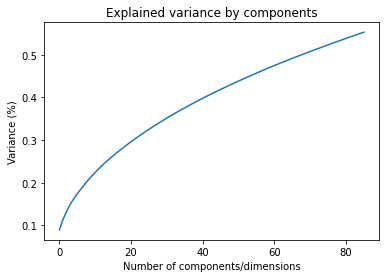

In [10]:
# Plot the cumulative explained variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components/dimensions')
plt.ylabel('Variance (%)')
plt.title('Explained variance by components')
plt.show()

Text(0, 0.5, 'variance %')

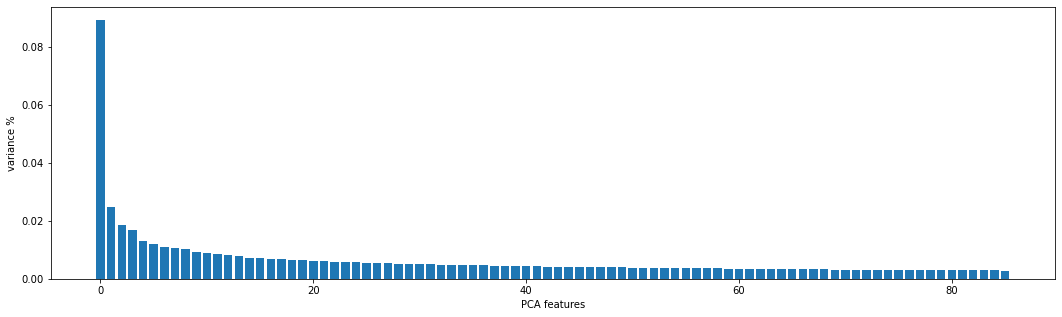

In [11]:
# Plot the explained variances
features = range(pca.n_components_)
f, ax = plt.subplots(figsize=(18,5))
plt.bar(features, pca.explained_variance_ratio_)
plt.xlabel('PCA features')
plt.ylabel('variance %')


In [12]:
#Set the PCA to 6 componets
pca = PCA(n_components = 6)

df_pca = pd.DataFrame(pca.fit_transform(df_units_scaled), index=df_units_scaled.index)
df_pca.columns = df_pca.columns.astype(str)
df_pca = df_pca.add_prefix('PC_')
df_pca

PC_0       PC_1      PC_2       PC_3       PC_4  \
Point-of-Sale_ID                                                         
1                  1.726353 -11.316083  8.688148   3.238344 -14.492191   
2                -21.058056   0.234556  1.626418  -1.578659  -3.152911   
3                 -9.280159 -15.205778  6.395939   4.980007  -6.421217   
4                 25.545837 -24.915367  9.465256  -1.806171  -4.037138   
5                -15.422590  -3.923032  2.236672  -0.227423  -0.456555   
...                     ...        ...       ...        ...        ...   
406              -15.197373   1.146528  1.432608  11.363838   4.835776   
407                2.194339  -9.553514  0.118233  28.612236  11.936365   
408              -18.139433   2.411797  0.239159   4.597152   6.277000   
409              -17.230930   4.756803 -2.811394   5.867085   9.163993   
410               21.180386  -7.983813 -6.201027  15.843328  16.183262   

                      PC_5  
Point-of-Sale_ID            
1                 2.045253  
2                 2.460183  
3                 4.418422  
4                -5.804585  
5                 0.652289  
...                    ...  
406               4.517504  
407               9.598480  
408               3.599928  
409               4.260205  
410              -3.096506  

[410 rows x 6 columns]

In [12]:
#function for the elbow plot
def elbow(df):
    inertia = []
    range_clusters = range(1,50)
    for n_clus in range_clusters:
        kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
        kmclust.fit(df)
        inertia.append(kmclust.inertia_) 
        
    plt.figure(figsize=(9,5))
    plt.plot(inertia)
    plt.ylabel("Inertia: SSw")
    plt.xlabel("Number of clusters")
    plt.title("Inertia plot over clusters", size=15)
    plt.show()
    
elbow(df_pca)

NameError: name 'df_pca' is not defined

In [33]:
#K-means Clustering functions
def clus_Kmeans(df, nclust):
    model = KMeans(nclust, random_state=0)
    model.fit(df)
    clust_labels = model.predict(df)
    cent = model.cluster_centers_
    return (clust_labels, cent)

def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(s=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
        

    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show() 
    
# Valuation metrics functions
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst

def get_ss_variables(df):
    """Get the SS for each variable
    """
    ss_vars = df.var() * (df.count() - 1)
    return ss_vars

def r2_variables(df, labels):
    """Get the R² for each variable
    """
    sst_vars = get_ss_variables(df)
    ssw_vars = np.sum(df.groupby(labels).apply(get_ss_variables))
    return 1 - ssw_vars/sst_vars

### K-means

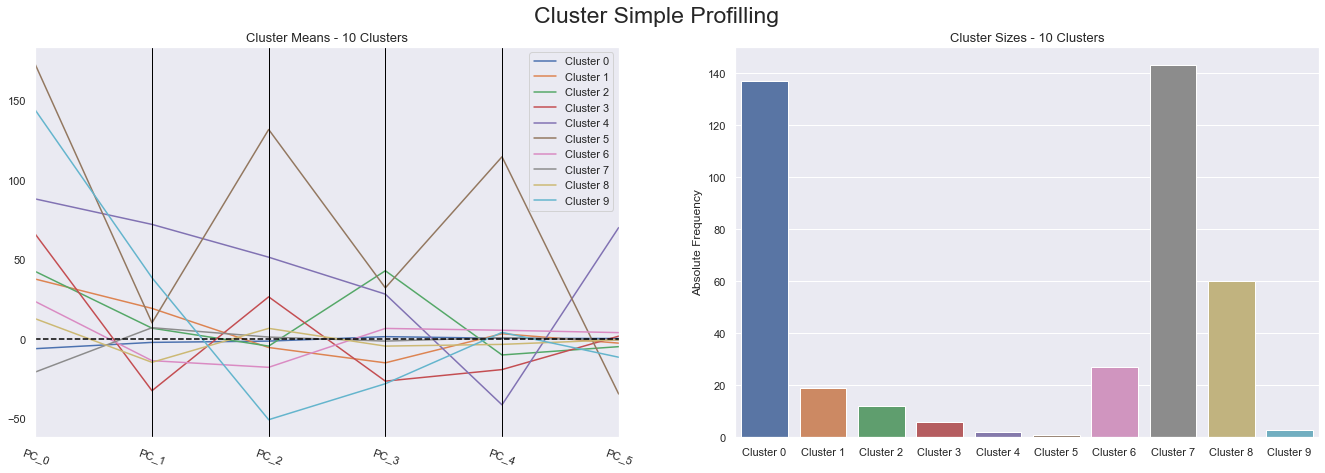

In [15]:
#Plot cluster variability of each feature in the cluster adn the cluster size
clust_labels, cent = clus_Kmeans(df_pca, 10)
kmeans_df_prod = df_pca.copy()
kmeans_df_prod["k_labels_prod"] = clust_labels
cluster_profiles(kmeans_df_prod, ["k_labels_prod"], figsize=(23, 7))

In [16]:
#R2 of each feature
r2_variables(kmeans_df_prod, ['k_labels_prod']).drop('k_labels_prod').sort_values()

PC_5    0.295397
PC_4    0.483136
PC_1    0.630767
PC_3    0.661612
PC_2    0.733131
PC_0    0.878636
dtype: float64

In [17]:
#Global cluster r2
r2(kmeans_df_prod, ["k_labels_prod"])

0.7395157828417704

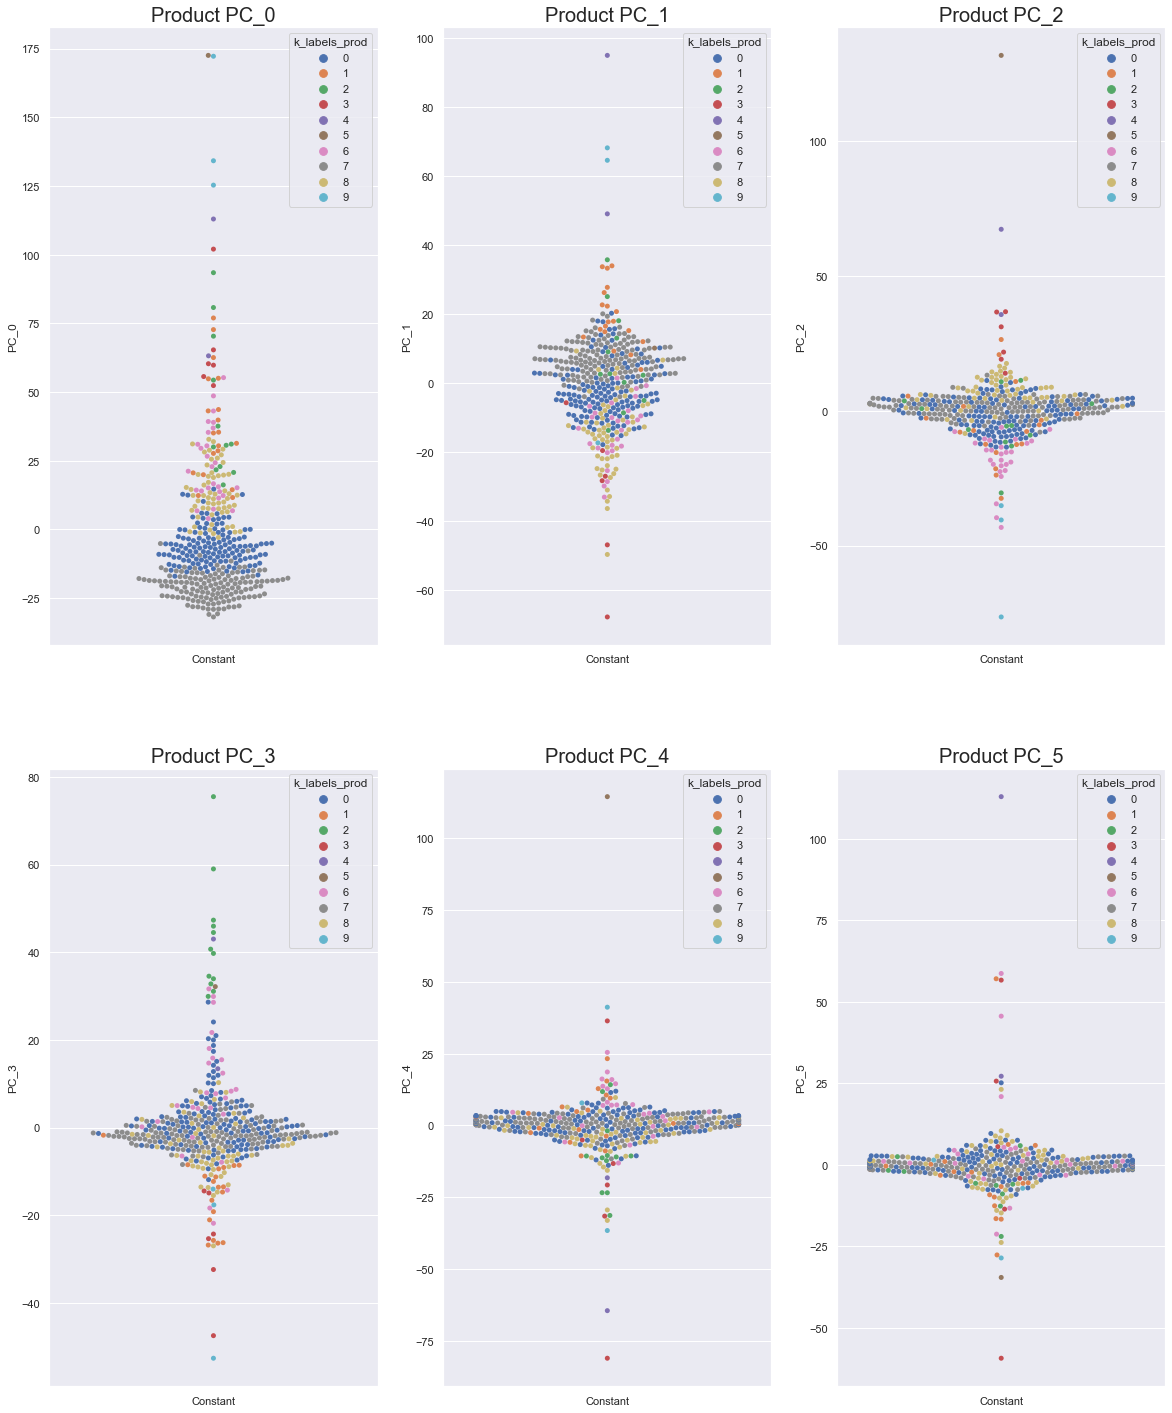

In [18]:
#violin plots of each feature considering the clusters
violin_df = kmeans_df_prod.copy()
violin_df['Constant'] = 'Constant'

i = 0
q = 0
sns.set()

fig, axarr = plt.subplots(2,3, figsize=(20, 25))
#swarmplot stripplot
for x in list(kmeans_df_prod.columns[:-1]):
    sns.swarmplot(x=violin_df['Constant'],y=violin_df[x],hue=violin_df['k_labels_prod'], ax=axarr[q][i])
    axarr[q][i].set(xlabel=None)
    axarr[q][i].set_title(f"Product {x}", fontsize=20)
    if i < 2:
        i+=1
    else:
        i=0
        q+=1

### GMM

In [19]:
#Try with GMM instead of k-means to see the impacts
from sklearn.mixture import GaussianMixture

def doGMM(df, nclust):
    model=GaussianMixture(n_components=nclust, init_params='kmeans', random_state=0)
    model.fit(df)
    clust_labels = model.predict(df)
    return(clust_labels)

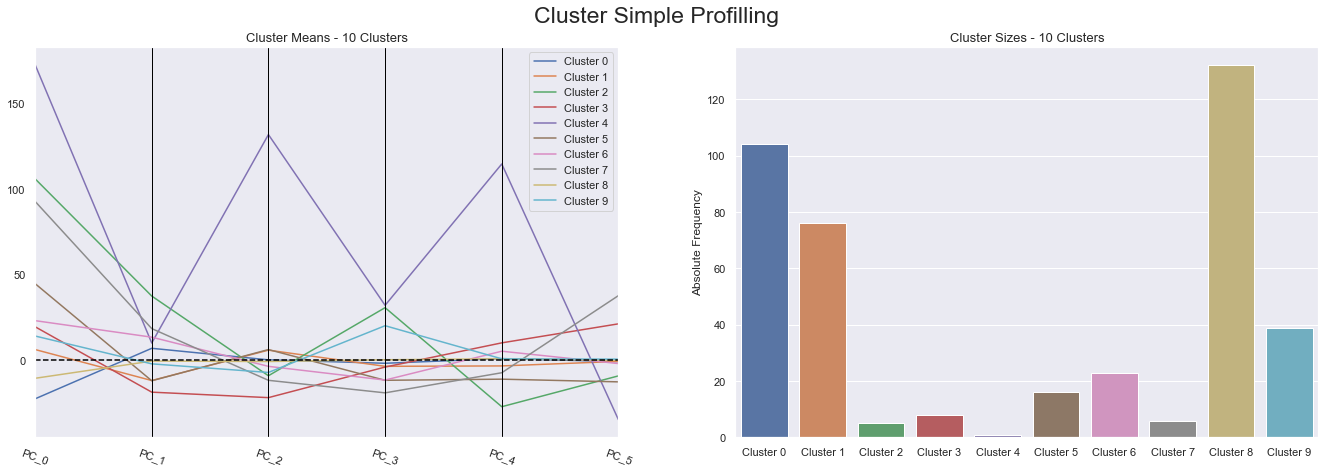

In [20]:
clust_labels = doGMM(df_pca, 10)
gmm_df = df_pca.copy()
gmm_df["gmm_labels"] = clust_labels
cluster_profiles(gmm_df, ["gmm_labels"], figsize=(23, 7))

In [21]:
r2_variables(gmm_df, ['gmm_labels']).drop('gmm_labels').sort_values()

PC_5    0.394182
PC_1    0.395496
PC_2    0.435523
PC_4    0.476069
PC_3    0.522106
PC_0    0.843768
dtype: float64

In [22]:
r2(gmm_df, ["gmm_labels"])

0.6506889841242873

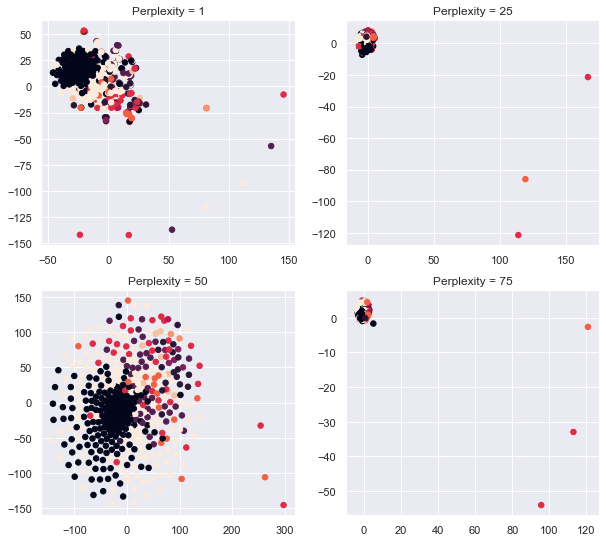

In [23]:
#TSNE visual using k-means clusters
plt.figure(figsize = (10,5))
plt.subplots_adjust(top = 1.5)

for index, p in enumerate([1, 25, 50, 75]):

    tsne = TSNE(n_components = 2, perplexity = p, random_state=0)
    tsne_results = tsne.fit_transform(df_units_scaled)
    
    tsne_results=pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2'])
    
    plt.subplot(2,2,index+1)
    plt.scatter(tsne_results['tsne1'], tsne_results['tsne2'], c=kmeans_df_prod['k_labels_prod'], s=30)
    plt.title('Perplexity = '+ str(p))
plt.show()

# Clustering by Family

In [48]:
df_fam = df[['Point-of-Sale_ID','ProductFamily_ID','Value_units','Value_price']]
df_fam

Point-of-Sale_ID  ProductFamily_ID  Value_units  Value_price
0                        1                16          2.0       1540.0
1                        1                16          4.0       3080.0
2                        1                16          2.0       1540.0
3                        1                16          2.0       1620.0
4                        1                16          2.0       1620.0
...                    ...               ...          ...          ...
91191593               410                 4          1.0        643.0
91191594               410                 4          1.0        638.0
91191595               410                 4          1.0        652.0
91191596               410                 4          1.0        643.0
91191597               410                 4          1.0        638.0

[91191598 rows x 4 columns]

In [49]:
grouped_df_fam_units = df_fam.groupby(['Point-of-Sale_ID','ProductFamily_ID'])['Value_units'].sum().to_frame()
grouped_df_fam_units.reset_index(inplace=True)
grouped_df_fam_prices = df_fam.groupby(['Point-of-Sale_ID','ProductFamily_ID'])['Value_price'].sum().to_frame()
grouped_df_fam_prices.reset_index(inplace=True)
grouped_df_fam = pd.merge(grouped_df_fam_units,grouped_df_fam_prices['Value_price'],left_index=True, right_index=True)
grouped_df_fam

Point-of-Sale_ID  ProductFamily_ID  Value_units  Value_price
0                    1                 1     103022.0   80371664.0
1                    1                 2      40434.0  180931760.0
2                    1                 3      10972.0   50499980.0
3                    1                 4        531.0     360248.0
4                    1                 5       8019.0    4599321.5
...                ...               ...          ...          ...
8605               410                17        180.0     149979.0
8606               410                18      62610.0  113501136.0
8607               410                19       2106.0   11161800.0
8608               410                20       1007.0    1660049.0
8609               410                21      90621.0  154055456.0

[8610 rows x 4 columns]

In [26]:
df_fam_units_pivot = grouped_df_fam.pivot(index='Point-of-Sale_ID',columns='ProductFamily_ID', values='Value_units').fillna(0)
df_fam_units_pivot


ProductFamily_ID        1        2        3      4       5        6       7   \
Point-of-Sale_ID                                                               
1                 103022.0  40434.0  10972.0  531.0  8019.0   8985.0  3608.0   
2                  70985.0  31079.0   7481.0   88.0  5632.0   6698.0  3276.0   
3                 103916.0  46550.0  14466.0  368.0  8810.0  12972.0  9186.0   
4                 115308.0  47610.0  12973.0  273.0  9886.0  16528.0  4006.0   
5                  63043.0  30783.0   8328.0  205.0  6637.0   7582.0  2622.0   
...                    ...      ...      ...    ...     ...      ...     ...   
406                91065.0  47003.0   8255.0  222.0  4099.0   5781.0  2025.0   
407               136214.0  75049.0  19143.0  704.0  4562.0   6019.0  4573.0   
408                79938.0  41854.0  13267.0  688.0  3390.0   2890.0  2275.0   
409                80296.0  41001.0   9707.0  431.0  3143.0   3761.0  2536.0   
410               148350.0  63449.0  13737.0  778.0  5234.0  11169.0  4979.0   

ProductFamily_ID       8         9       10  ...        12      13       14  \
Point-of-Sale_ID                             ...                              
1                 15437.0  141690.0  6049.0  ...   99181.0  3831.0  30819.0   
2                 12038.0   95055.0  1834.0  ...   61220.0  1936.0  20424.0   
3                 17113.0  169859.0  2456.0  ...   85415.0  2445.0  23886.0   
4                 18516.0  198227.0  6231.0  ...  154111.0  3986.0  37685.0   
5                  8752.0  119363.0  2654.0  ...   72143.0  2144.0  19739.0   
...                   ...       ...     ...  ...       ...     ...      ...   
406                9739.0  116195.0  2632.0  ...   81628.0  2306.0  19048.0   
407               13767.0  172611.0  4049.0  ...  140034.0  4140.0  35103.0   
408                7320.0   93445.0  2396.0  ...   82549.0  2652.0  21406.0   
409                8066.0   94419.0  2431.0  ...   86282.0  2412.0  20773.0   
410               15157.0  161873.0  6016.0  ...  173950.0  4731.0  54469.0   

ProductFamily_ID       15       16     17       18      19      20       21  
Point-of-Sale_ID                                                             
1                 37835.0   8050.0  485.0  38761.0  1037.0   226.0  49567.0  
2                 25716.0   7020.0   49.0  20959.0   512.0    93.0  17995.0  
3                 38790.0   7803.0  168.0  24814.0   974.0    79.0  31563.0  
4                 45622.0   7154.0  601.0  35230.0  2770.0   571.0  78415.0  
5                 23803.0   5566.0  203.0  22406.0   741.0   175.0  25402.0  
...                   ...      ...    ...      ...     ...     ...      ...  
406               20975.0   6432.0  195.0  36854.0  1033.0   408.0  37524.0  
407               34286.0  12818.0  292.0  62458.0   716.0   546.0  57593.0  
408               25206.0   9328.0   41.0  37932.0   629.0    75.0  28481.0  
409               15359.0   5156.0  124.0  36699.0  1522.0   175.0  30386.0  
410               31662.0  14994.0  180.0  62610.0  2106.0  1007.0  90621.0  

[410 rows x 21 columns]

In [27]:

scaler = StandardScaler()
df_fam_units_scaled = pd.DataFrame(scaler.fit_transform(df_fam_units_pivot),columns=df_fam_units_pivot.columns, index=df_fam_units_pivot.index)
df_fam_units_scaled


ProductFamily_ID        1         2         3         4         5         6   \
Point-of-Sale_ID                                                               
1                 0.663792  0.465872  1.231042  0.140960  0.907485  0.440215   
2                -0.229083 -0.144103  0.282701 -1.318207  0.105504 -0.123682   
3                 0.688708  0.864654  2.180199 -0.395935  1.173244  1.423275   
4                 1.006204  0.933769  1.774620 -0.708849  1.534757  2.300065   
5                -0.450427 -0.163403  0.512791 -0.932829  0.443163  0.094283   
...                    ...       ...       ...       ...       ...       ...   
406               0.330549  0.894191  0.492961 -0.876834 -0.409552 -0.349783   
407               1.588856  2.722877  3.450721  0.710793 -0.253993 -0.291100   
408               0.020438  0.558460  1.854486  0.658091 -0.647760 -1.062606   
409               0.030416  0.502842  0.887401 -0.188423 -0.730747 -0.847847   
410               1.927088  1.966521  1.982164  0.954536 -0.028216  0.978716   

ProductFamily_ID        7         8         9         10  ...        12  \
Point-of-Sale_ID                                          ...             
1                 0.228120  0.763597  0.677737  0.864886  ...  0.299103   
2                 0.041333  0.106852 -0.268924 -0.923047  ... -0.643033   
3                 3.366366  1.087430  1.249550 -0.659205  ... -0.042549   
4                 0.452039  1.358513  1.825403  0.942087  ...  1.662385   
5                -0.326615 -0.528061  0.224513 -0.575216  ... -0.371941   
...                    ...       ...       ...       ...  ...       ...   
406              -0.662494 -0.337355  0.160205 -0.584548  ... -0.136537   
407               0.771040  0.440924  1.305414  0.016519  ...  1.313014   
408              -0.521841 -0.804748 -0.301606 -0.684656  ... -0.113679   
409              -0.375000 -0.660608 -0.281835 -0.669809  ... -0.021031   
410               0.999460  0.709496  1.087440  0.850888  ...  2.154759   

ProductFamily_ID        13        14        15        16        17        18  \
Point-of-Sale_ID                                                               
1                 0.910410  0.089515  0.828914  0.472502 -0.027541  0.870742   
2                -0.357855 -0.584619 -0.143172  0.184383 -0.955913 -0.458966   
3                -0.017197 -0.360102  0.905516  0.403409 -0.702527 -0.171020   
4                 1.014146  0.534787  1.453523  0.221866  0.219458  0.606996   
5                -0.218647 -0.629042 -0.296617 -0.222340 -0.628002 -0.350884   
...                    ...       ...       ...       ...       ...       ...   
406              -0.110225 -0.673855 -0.523456  0.019904 -0.645036  0.728300   
407               1.117214  0.367340  0.544243  1.806240 -0.438494  2.640773   
408               0.121342 -0.520934 -0.184080  0.829993 -0.972947  0.808820   
409              -0.039283 -0.561985 -0.973925 -0.337028 -0.796216  0.716722   
410               1.512752  1.623259  0.333767  2.414926 -0.676975  2.652127   

ProductFamily_ID        19        20        21  
Point-of-Sale_ID                                
1                -0.357827 -0.608786  0.256918  
2                -0.913404 -0.730637 -0.767792  
3                -0.424496 -0.743464 -0.327425  
4                 1.476104 -0.292706  1.193218  
5                -0.671067 -0.655511 -0.527389  
...                    ...       ...       ...  
406              -0.362060 -0.442043 -0.133953  
407              -0.697523 -0.315611  0.517413  
408              -0.789589 -0.747128 -0.427455  
409               0.155419 -0.655511 -0.365626  
410               0.773432  0.106745  1.589380  

[410 rows x 21 columns]

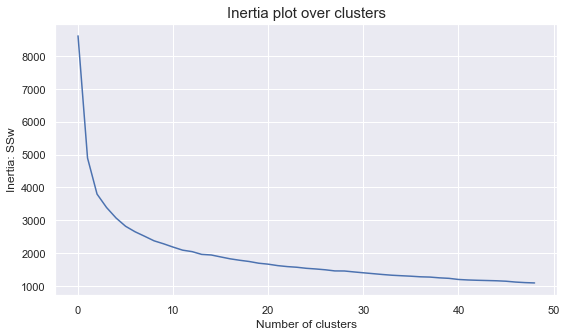

In [28]:
elbow(df_fam_units_scaled)

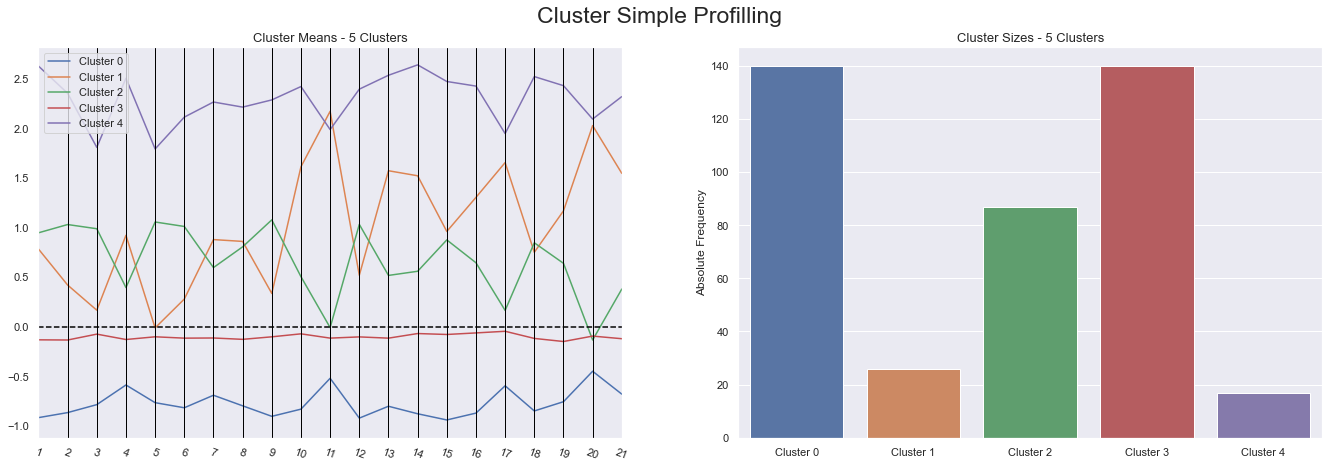

In [29]:
clust_labels, cent = clus_Kmeans(df_fam_units_scaled, 5)
kmeans_df_fam = df_fam_units_scaled.copy()
kmeans_df_fam["k_labels_fam"] = clust_labels
cluster_profiles(kmeans_df_fam, ["k_labels_fam"], figsize=(23, 7))

In [30]:
r2_variables(kmeans_df_fam, ['k_labels_fam']).drop('k_labels_fam').sort_values()

ProductFamily_ID
17    0.459621
4     0.471687
7     0.505868
20    0.519445
3     0.558425
11    0.561151
21    0.569605
5     0.574970
8     0.611938
19    0.622510
6     0.640975
10    0.701375
16    0.702168
18    0.704012
13    0.705928
2     0.730085
9     0.754409
14    0.768620
12    0.776296
15    0.780249
1     0.810331
dtype: float64

In [31]:
r2(kmeans_df_fam, ["k_labels_fam"])

0.6728264647646747

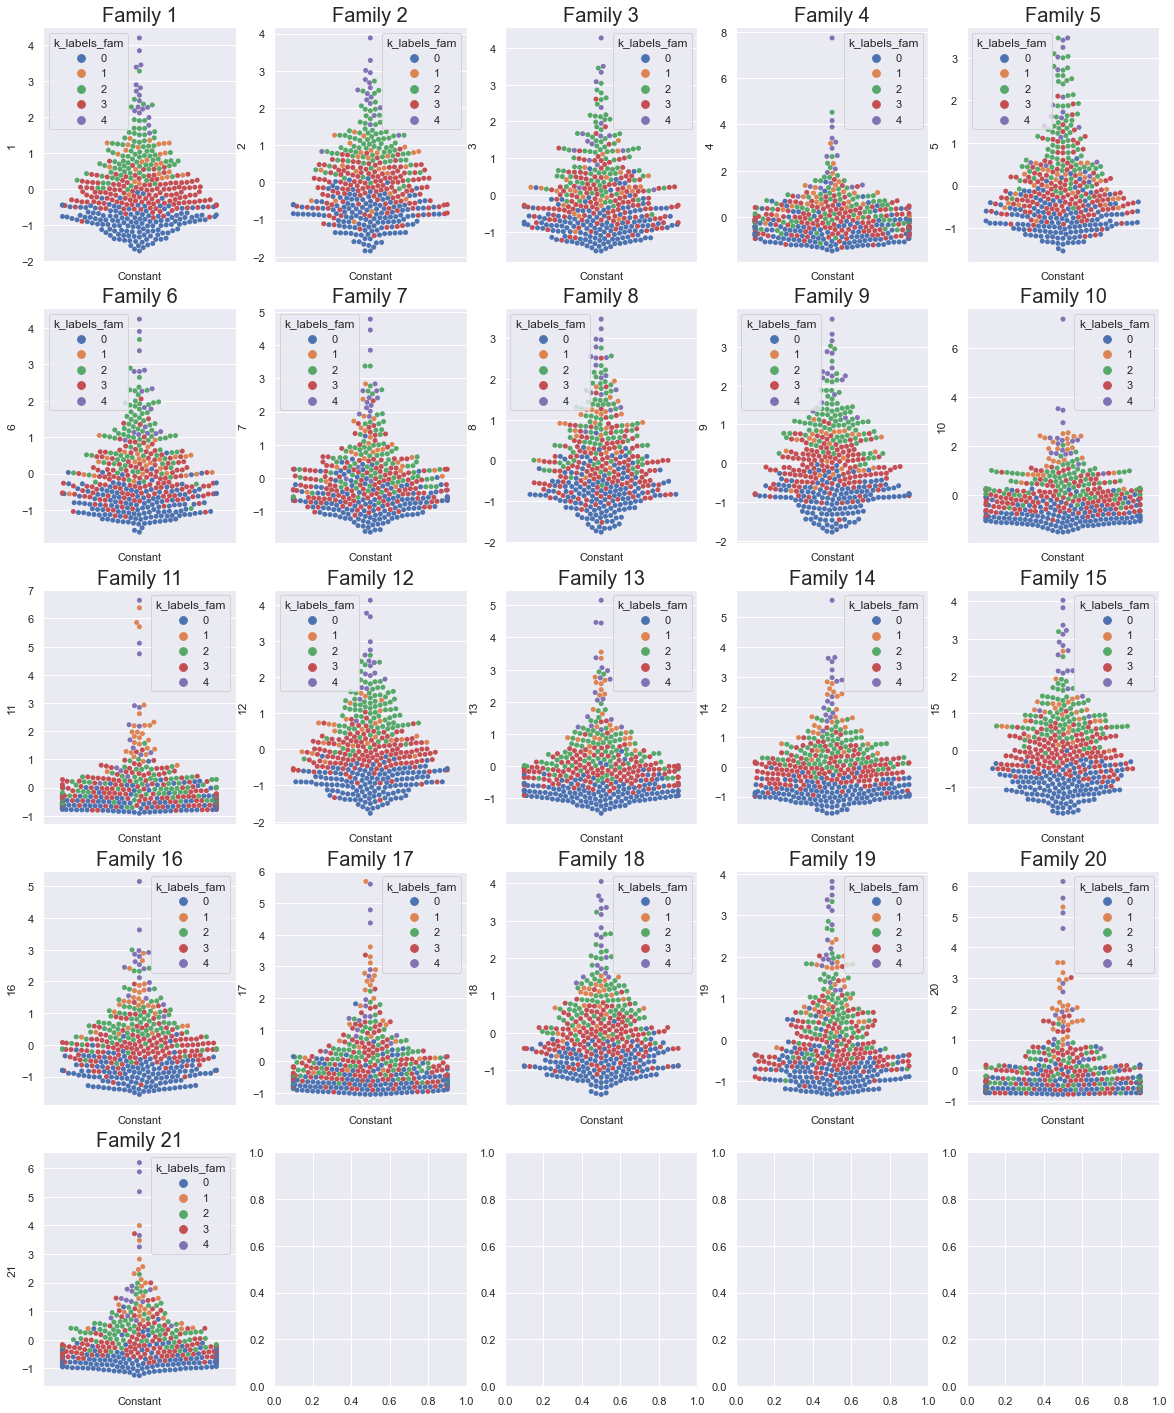

In [33]:
violin_df = kmeans_df_fam.copy()
violin_df['Constant'] = 'Constant'

i = 0
q = 0
sns.set()

fig, axarr = plt.subplots(5,5, figsize=(20, 25))
#swarmplot stripplot
for x in list(violin_df.columns[:-2]):
    sns.swarmplot(x=violin_df['Constant'],y=violin_df[x],hue=violin_df['k_labels_fam'], ax=axarr[q][i])
    axarr[q][i].set(xlabel=None)
    axarr[q][i].set_title(f"Family {x}", fontsize=20)
    if i < 4:
        i+=1
    else:
        i=0
        q+=1

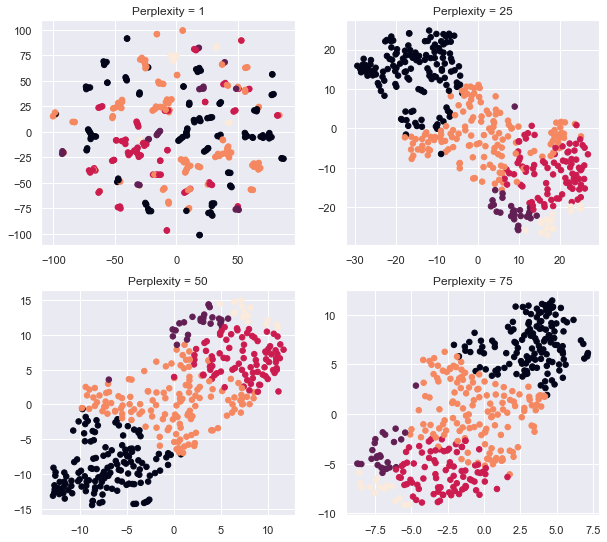

In [34]:
#check different perplexity levels for 2D visualization

plt.figure(figsize = (10,5))
plt.subplots_adjust(top = 1.5)

for index, p in enumerate([1, 25, 50, 75]):

    tsne = TSNE(n_components = 2, perplexity = p, random_state=0)
    tsne_results = tsne.fit_transform(df_fam_units_scaled)
    
    tsne_results=pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2'])
    
    plt.subplot(2,2,index+1)
    plt.scatter(tsne_results['tsne1'], tsne_results['tsne2'], c=kmeans_df_fam['k_labels_fam'], s=30)
    plt.title('Perplexity = '+ str(p))
plt.show()

# Clustering by Category

In [23]:
df_categ = df[['Point-of-Sale_ID','ProductCategory_ID','Value_units','Value_price']]
df_categ

Point-of-Sale_ID  ProductCategory_ID  Value_units  Value_price
0                        1                  11          2.0       1540.0
1                        1                  11          4.0       3080.0
2                        1                  11          2.0       1540.0
3                        1                  11          2.0       1620.0
4                        1                  11          2.0       1620.0
...                    ...                 ...          ...          ...
91191593               410                  34          1.0        643.0
91191594               410                  34          1.0        638.0
91191595               410                  34          1.0        652.0
91191596               410                  34          1.0        643.0
91191597               410                  34          1.0        638.0

[91191598 rows x 4 columns]

In [24]:
grouped_df_categ_units = df_categ.groupby(['Point-of-Sale_ID','ProductCategory_ID'])['Value_units'].sum().to_frame()
grouped_df_categ_units.reset_index(inplace=True)
grouped_df_categ_prices = df_categ.groupby(['Point-of-Sale_ID','ProductCategory_ID'])['Value_price'].sum().to_frame()
grouped_df_categ_prices.reset_index(inplace=True)
grouped_df_categ = pd.merge(grouped_df_categ_units,grouped_df_categ_prices['Value_price'],left_index=True, right_index=True)
grouped_df_categ

Point-of-Sale_ID  ProductCategory_ID  Value_units   Value_price
0                     1                   1       4561.0  3.527857e+06
1                     1                   2       9967.0  7.070405e+06
2                     1                   3      18463.0  1.547655e+07
3                     1                   4       1768.0  2.122175e+06
4                     1                   5         90.0  3.744000e+04
...                 ...                 ...          ...           ...
53120               410                 170         15.0  3.635000e+04
53121               410                 172       2106.0  1.116180e+07
53122               410                 173        391.0  5.133830e+05
53123               410                 175      62219.0  1.129878e+08
53124               410                 178     594870.0  9.963840e+08

[53125 rows x 4 columns]

In [25]:
df_categ_units_pivot = grouped_df_categ.pivot(index='Point-of-Sale_ID',columns='ProductCategory_ID', values='Value_units').fillna(0)
df_categ_units_pivot

ProductCategory_ID     1        2        3       4      5      6       7    \
Point-of-Sale_ID                                                             
1                   4561.0   9967.0  18463.0  1768.0   90.0   82.0  3153.0   
2                   2921.0   7211.0  12129.0   689.0   52.0  108.0  2628.0   
3                   4141.0  13425.0  17039.0   770.0   61.0  102.0  3398.0   
4                   8268.0  14503.0  17233.0  3026.0   81.0   96.0  2469.0   
5                   3696.0   6678.0  10597.0  1307.0   50.0   40.0  1497.0   
...                    ...      ...      ...     ...    ...    ...     ...   
406                 1721.0   6013.0  10611.0   810.0  239.0   10.0  1577.0   
407                 5015.0   5450.0  17946.0  1751.0   12.0   93.0  4022.0   
408                 3920.0   4385.0  11916.0   997.0    6.0   26.0  3986.0   
409                 1587.0   3106.0   8771.0   669.0    3.0   17.0  1225.0   
410                 3877.0   6942.0  16962.0  1563.0    4.0   77.0  2242.0   

ProductCategory_ID  8       9        10   ...   169   170  171     172    173  \
Point-of-Sale_ID                          ...                                   
1                   0.0  1432.0   3912.0  ...  28.0   8.0  0.0  1037.0   42.0   
2                   0.0   776.0    169.0  ...   1.0   0.0  0.0   512.0   39.0   
3                   0.0  1387.0   3203.0  ...   0.0   8.0  0.0   974.0   10.0   
4                   0.0  1326.0   5756.0  ...  36.0  10.0  0.0  2769.0  219.0   
5                   0.0   685.0   3096.0  ...  10.0   0.0  0.0   741.0  447.0   
...                 ...     ...      ...  ...   ...   ...  ...     ...    ...   
406                 0.0   368.0   5100.0  ...   9.0   0.0  0.0  1033.0  154.0   
407                 0.0  1867.0   6084.0  ...   0.0   1.0  0.0   716.0  277.0   
408                 0.0  1341.0   2062.0  ...   0.0   2.0  0.0   618.0  195.0   
409                 0.0   758.0   4591.0  ...   6.0   0.0  0.0  1260.0  109.0   
410                 0.0  2148.0  10565.0  ...  25.0  15.0  0.0  2106.0  391.0   

ProductCategory_ID    174      175  176   177       178  
Point-of-Sale_ID                                         
1                     0.0  38717.0  0.0   2.0  429762.0  
2                     0.0  20920.0  0.0   0.0  293021.0  
3                     0.0  24804.0  0.0   0.0  467500.0  
4                     1.0  35011.0  0.0   0.0  575427.0  
5                     0.0  21958.0  0.0   1.0  318579.0  
...                   ...      ...  ...   ...       ...  
406                   0.0  36697.0  0.0   3.0  365004.0  
407                   0.0  62181.0  0.0   0.0  570859.0  
408                  11.0  37736.0  0.0   1.0  326070.0  
409                 227.0  36590.0  0.0  35.0  328480.0  
410                   0.0  62219.0  0.0   0.0  594870.0  

[410 rows x 178 columns]

In [26]:
from sklearn.preprocessing import QuantileTransformer
scaler = QuantileTransformer()
df_categ_units_scaled = pd.DataFrame(scaler.fit_transform(df_categ_units_pivot),columns=df_categ_units_pivot.columns, index=df_categ_units_pivot.index)
df_categ_units_scaled

ProductCategory_ID       1         2         3         4         5    \
Point-of-Sale_ID                                                       
1                   0.838631  0.559902  0.904646  0.960880  0.678484   
2                   0.546455  0.278729  0.611247  0.603912  0.503667   
3                   0.782396  0.772616  0.870416  0.655257  0.556235   
4                   0.997555  0.814181  0.877751  0.997555  0.645477   
5                   0.718826  0.246944  0.506112  0.880196  0.493888   
...                      ...       ...       ...       ...       ...   
406                 0.239609  0.205379  0.508557  0.684597  0.877751   
407                 0.892421  0.154034  0.894866  0.958435  0.224939   
408                 0.765281  0.092910  0.599022  0.787286  0.128362   
409                 0.200489  0.024450  0.339853  0.594132  0.063570   
410                 0.760391  0.264059  0.865526  0.926650  0.086797   

ProductCategory_ID       6         7    8         9         10   ...  \
Point-of-Sale_ID                                                 ...   
1                   0.672372  0.833741  0.0  0.880196  0.833741  ...   
2                   0.766504  0.704156  0.0  0.633252  0.007335  ...   
3                   0.753056  0.872861  0.0  0.870416  0.745721  ...   
4                   0.724939  0.669927  0.0  0.858191  0.953545  ...   
5                   0.343521  0.382641  0.0  0.578240  0.731051  ...   
...                      ...       ...  ...       ...       ...  ...   
406                 0.053790  0.415648  0.0  0.322738  0.931540  ...   
407                 0.705379  0.924205  0.0  0.952323  0.963325  ...   
408                 0.198044  0.916870  0.0  0.860636  0.509780  ...   
409                 0.114914  0.292176  0.0  0.621027  0.914425  ...   
410                 0.651589  0.611247  0.0  0.975550  0.990220  ...   

ProductCategory_ID       169       170  171       172       173       174  \
Point-of-Sale_ID                                                            
1                   0.931540  0.693154  0.0  0.475550  0.217604  0.000000   
2                   0.282396  0.000000  0.0  0.158924  0.194377  0.000000   
3                   0.000000  0.693154  0.0  0.422983  0.037897  0.000000   
4                   0.954768  0.739609  0.0  0.904646  0.710269  0.858191   
5                   0.640587  0.000000  0.0  0.283619  0.909535  0.000000   
...                      ...       ...  ...       ...       ...       ...   
406                 0.600245  0.000000  0.0  0.470660  0.600245  0.000000   
407                 0.000000  0.369193  0.0  0.273839  0.767726  0.000000   
408                 0.000000  0.432763  0.0  0.207824  0.660147  0.970660   
409                 0.485330  0.000000  0.0  0.569682  0.482885  1.000000   
410                 0.908313  0.849633  0.0  0.823961  0.880196  0.000000   

ProductCategory_ID       175  176       177       178  
Point-of-Sale_ID                                       
1                   0.833741  0.0  0.452323  0.755501  
2                   0.374083  0.0  0.000000  0.440098  
3                   0.515892  0.0  0.000000  0.816626  
4                   0.765281  0.0  0.000000  0.926650  
5                   0.427873  0.0  0.333741  0.503667  
...                      ...  ...       ...       ...  
406                 0.801956  0.0  0.520782  0.618582  
407                 0.977995  0.0  0.000000  0.921760  
408                 0.819071  0.0  0.333741  0.528117  
409                 0.799511  0.0  0.900978  0.533007  
410                 0.980440  0.0  0.000000  0.936430  

[410 rows x 178 columns]

In [27]:
#reduce to number of components85% variability

pca = PCA(n_components = 0.55, svd_solver = 'full')

df_categ_pca = pd.DataFrame(pca.fit_transform(df_categ_units_scaled), index=df_categ_units_scaled.index)
df_categ_pca.columns = df_categ_pca.columns.astype(str)
df_categ_pca = df_categ_pca.add_prefix('PC_')
df_categ_pca

PC_0      PC_1      PC_2      PC_3      PC_4
Point-of-Sale_ID                                                  
1                 0.890619 -0.892106 -0.536508 -0.824947  0.213600
2                -3.167924 -0.661774 -0.719745 -0.612954 -0.177658
3                -0.764771 -0.452055 -1.238401 -0.535483  0.248123
4                 2.996125 -0.300435 -1.112841 -0.462624  0.583041
5                -1.960035 -0.340188  0.067037 -0.725446 -0.220859
...                    ...       ...       ...       ...       ...
406              -1.280764 -1.134565  0.864984 -0.573180  0.468565
407               0.845258 -1.194940  0.175723 -0.360638  0.236128
408              -1.838642 -1.178693 -0.083518 -0.899239 -0.688537
409              -2.202439 -0.649859  0.899817 -0.539543  0.023203
410               2.740637 -0.266546 -0.222235 -0.253447  0.197506

[410 rows x 5 columns]

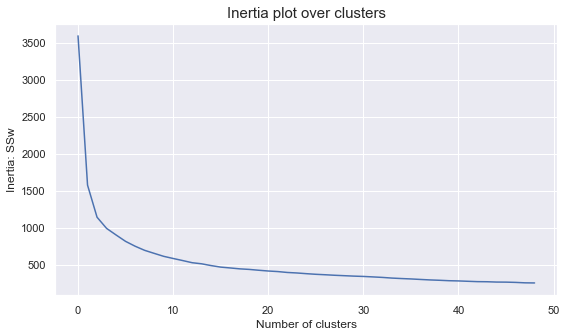

In [28]:
elbow(df_categ_pca)

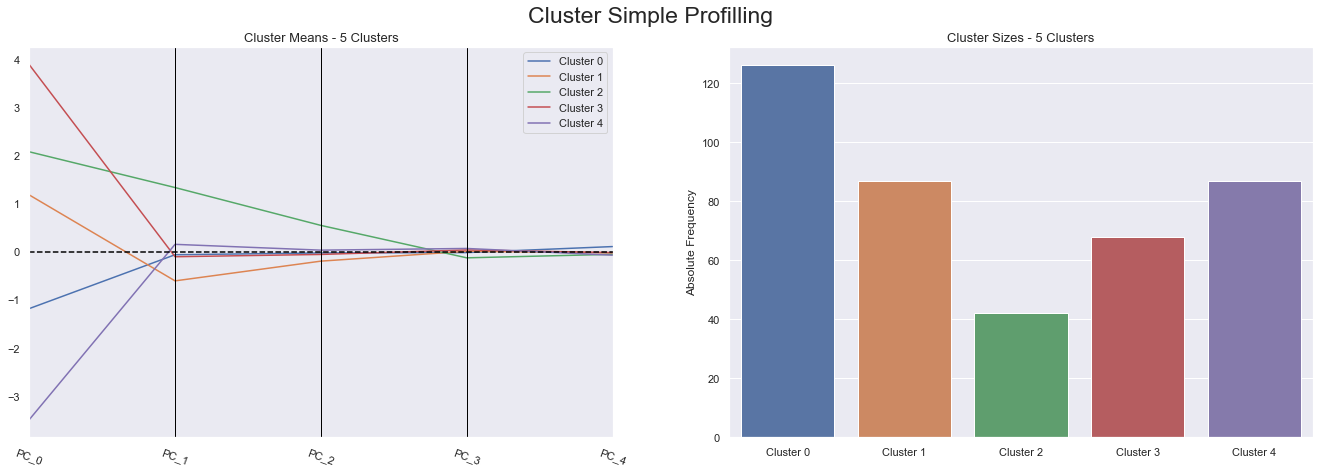

In [30]:
import seaborn as sns
clust_labels, cent = clus_Kmeans(df_categ_pca,5)
kmeans_df_categ = df_categ_pca.copy()
kmeans_df_categ["k_labels_categ"] = clust_labels
cluster_profiles(kmeans_df_categ, ["k_labels_categ"], figsize=(23, 7))

In [31]:
r2(kmeans_df_categ, ["k_labels_categ"])

0.8031993508624662

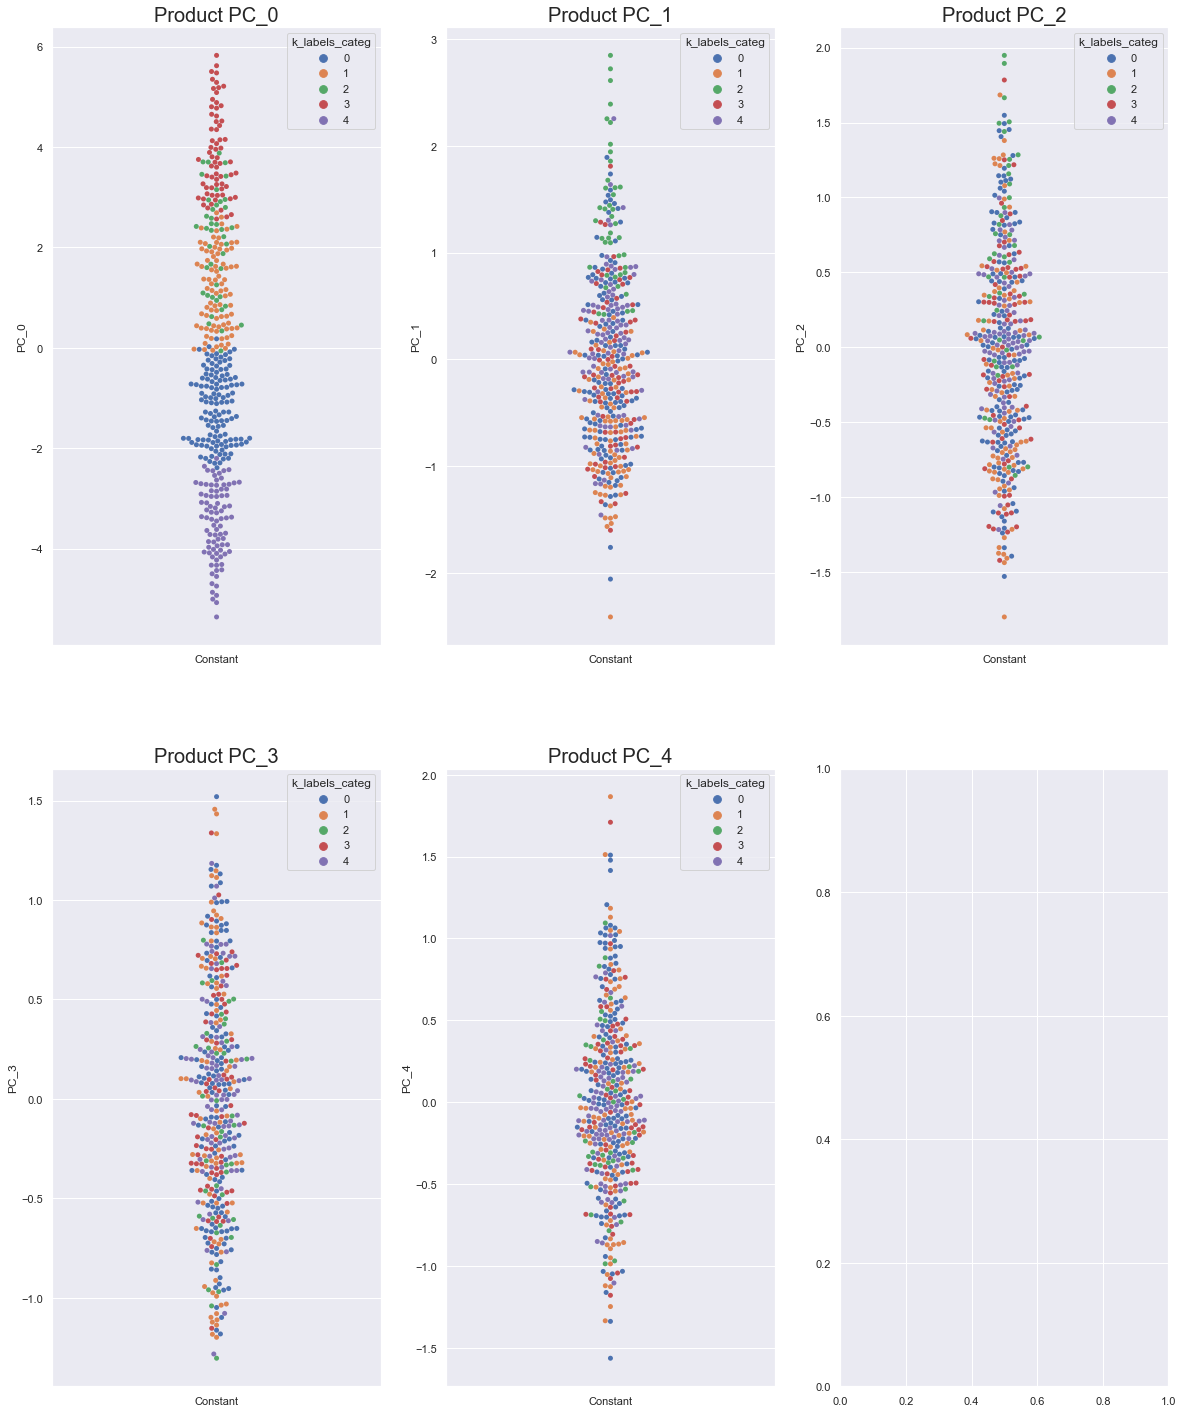

In [32]:
violin_df = kmeans_df_categ.copy()
violin_df['Constant'] = 'Constant'

i = 0
q = 0
sns.set()

fig, axarr = plt.subplots(2,3, figsize=(20, 25))
#swarmplot stripplot
for x in list(kmeans_df_categ.columns[:-1]):
    sns.swarmplot(x=violin_df['Constant'],y=violin_df[x],hue=violin_df['k_labels_categ'], ax=axarr[q][i])
    axarr[q][i].set(xlabel=None)
    axarr[q][i].set_title(f"Product {x}", fontsize=20)
    if i < 2:
        i+=1
    else:
        i=0
        q+=1

# Clulstering by Brand

In [45]:
df_brand = df[['Point-of-Sale_ID','ProductBrand_ID','Value_units','Value_price']]
df_brand

Point-of-Sale_ID  ProductBrand_ID  Value_units  Value_price
0                        1              306          2.0       1540.0
1                        1              306          4.0       3080.0
2                        1              306          2.0       1540.0
3                        1              306          2.0       1620.0
4                        1              306          2.0       1620.0
...                    ...              ...          ...          ...
91191593               410              279          1.0        643.0
91191594               410              279          1.0        638.0
91191595               410              279          1.0        652.0
91191596               410              279          1.0        643.0
91191597               410              279          1.0        638.0

[91191598 rows x 4 columns]

In [46]:
grouped_df_brand_units = df_brand.groupby(['Point-of-Sale_ID','ProductBrand_ID'])['Value_units'].sum().to_frame()
grouped_df_brand_units.reset_index(inplace=True)
grouped_df_brand_prices = df_brand.groupby(['Point-of-Sale_ID','ProductBrand_ID'])['Value_price'].sum().to_frame()
grouped_df_brand_prices.reset_index(inplace=True)
grouped_df_brand = pd.merge(grouped_df_brand_units,grouped_df_brand_prices['Value_price'],left_index=True, right_index=True)
grouped_df_brand

Point-of-Sale_ID  ProductBrand_ID  Value_units  Value_price
0                      1                1         49.0     96150.00
1                      1                4        856.0   1324995.00
2                      1                5       7276.0  13307804.00
3                      1                7        517.0    365115.00
4                      1               10         71.0     38420.00
...                  ...              ...          ...          ...
320836               410             1527        712.0   1544261.00
320837               410             1531       2879.0   2534670.50
320838               410             1532       2044.0   3438623.75
320839               410             1533       4831.0  23156180.00
320840               410             1535          2.0      3448.00

[320841 rows x 4 columns]

In [47]:
df_brand_units_pivot = grouped_df_brand.pivot(index='Point-of-Sale_ID',columns='ProductBrand_ID', values='Value_units').fillna(0)
df_brand_units_pivot

ProductBrand_ID    1     2     3       4        5     6      7      8     \
Point-of-Sale_ID                                                           
1                  49.0   0.0   0.0   856.0   7276.0   0.0  517.0    0.0   
2                  35.0   0.0   0.0   483.0   1261.0   0.0   22.0  122.0   
3                  23.0   0.0   0.0   459.0   5244.0   0.0  120.0   16.0   
4                 243.0   6.0   0.0   491.0   4317.0   0.0  369.0   61.0   
5                   7.0   0.0   0.0    56.0   2230.0   0.0    2.0    1.0   
...                 ...   ...   ...     ...      ...   ...    ...    ...   
406                 6.0  65.0   0.0  1739.0   3831.0   0.0    1.0    0.0   
407                13.0   0.0   0.0  1987.0   9895.0   0.0    0.0    0.0   
408                 0.0   0.0   0.0  1794.0   6358.0   0.0    0.0    0.0   
409                 0.0   0.0   0.0  1184.0   7190.0   0.0    0.0    0.0   
410                15.0   0.0   0.0  1807.0  13879.0   0.0    4.0    0.0   

ProductBrand_ID   9       10    ...  1526    1527  1528  1529  1530    1531  \
Point-of-Sale_ID                ...                                           
1                  0.0    71.0  ...   0.0   785.0   0.0   0.0   0.0  1039.0   
2                  0.0   365.0  ...   1.0   508.0   0.0   0.0   0.0   297.0   
3                  0.0   143.0  ...   0.0   531.0   0.0   0.0   0.0  1021.0   
4                  4.0   450.0  ...  10.0  1770.0   0.0   0.0   1.0  1835.0   
5                  0.0    91.0  ...   0.0   734.0   0.0   0.0   0.0   781.0   
...                ...     ...  ...   ...     ...   ...   ...   ...     ...   
406               20.0  1182.0  ...   0.0    43.0   0.0   0.0   0.0   446.0   
407                0.0  1438.0  ...   0.0   159.0   0.0   0.0   0.0  1800.0   
408                0.0  1718.0  ...   0.0  1153.0   0.0   0.0   0.0   606.0   
409               12.0   552.0  ...   0.0    66.0   0.0   0.0   0.0   960.0   
410                7.0   706.0  ...   0.0   712.0   0.0   0.0   0.0  2879.0   

ProductBrand_ID     1532    1533   1534  1535  
Point-of-Sale_ID                               
1                 1530.0  1782.0   30.0  57.0  
2                  345.0  3274.0   77.0  29.0  
3                  759.0  4553.0  269.0  43.0  
4                 1903.0  7163.0  112.0  54.0  
5                  643.0  3533.0   42.0  49.0  
...                  ...     ...    ...   ...  
406                210.0  4338.0    0.0  51.0  
407                784.0  8889.0    0.0  18.0  
408                477.0  7378.0    0.0   0.0  
409                566.0  2843.0    0.0   0.0  
410               2044.0  4831.0    0.0   2.0  

[410 rows x 1523 columns]

In [48]:
scaler = StandardScaler()
df_brand_units_scaled = pd.DataFrame(scaler.fit_transform(df_brand_units_pivot),columns=df_brand_units_pivot.columns, index=df_brand_units_pivot.index)
df_brand_units_scaled

ProductBrand_ID       1          2         3         4         5         6     \
Point-of-Sale_ID                                                                
1                -0.466027  -0.093757 -0.104805 -0.272402  0.659436 -0.251817   
2                -0.611296  -0.093757 -0.104805 -0.738943 -1.086019 -0.251817   
3                -0.735813  -0.093757 -0.104805 -0.768961  0.069783 -0.251817   
4                 1.546994   1.496878 -0.104805 -0.728936 -0.199217 -0.251817   
5                -0.901836  -0.093757 -0.104805 -1.273026 -0.804831 -0.251817   
...                    ...        ...       ...       ...       ...       ...   
406              -0.912212  17.138117 -0.104805  0.832037 -0.340247 -0.251817   
407              -0.839577  -0.093757 -0.104805  1.142231  1.419427 -0.251817   
408              -0.974470  -0.093757 -0.104805  0.900830  0.393047 -0.251817   
409              -0.974470  -0.093757 -0.104805  0.137854  0.634480 -0.251817   
410              -0.818824  -0.093757 -0.104805  0.917091  2.575519 -0.251817   

ProductBrand_ID       7         8         9         10    ...      1526  \
Point-of-Sale_ID                                          ...             
1                 1.146735 -0.727281 -0.349358 -0.824382  ... -0.453344   
2                -0.578314 -0.229067 -0.349358 -0.393677  ... -0.073240   
3                -0.236790 -0.661942 -0.349358 -0.718903  ... -0.453344   
4                 0.630963 -0.478174 -0.130926 -0.269153  ...  3.347698   
5                -0.648013 -0.723198 -0.349358 -0.795082  ... -0.453344   
...                    ...       ...       ...       ...  ...       ...   
406              -0.651498 -0.727281  0.742802  0.803214  ... -0.453344   
407              -0.654983 -0.727281 -0.349358  1.178250  ... -0.453344   
408              -0.654983 -0.727281 -0.349358  1.588445  ... -0.453344   
409              -0.654983 -0.727281  0.305938 -0.119725  ... -0.453344   
410              -0.641044 -0.727281  0.032898  0.105883  ... -0.453344   

ProductBrand_ID       1527      1528      1529      1530      1531      1532  \
Point-of-Sale_ID                                                               
1                 0.014868 -0.049447 -0.049447 -0.310585  0.089870  0.593340   
2                -0.312748 -0.049447 -0.049447 -0.310585 -1.026832 -1.032435   
3                -0.285546 -0.049447 -0.049447 -0.310585  0.062780 -0.464443   
4                 1.179857 -0.049447 -0.049447  0.021029  1.287841  1.105082   
5                -0.045451 -0.049447 -0.049447 -0.310585 -0.298417 -0.623590   
...                    ...       ...       ...       ...       ...       ...   
406              -0.862718 -0.049447 -0.049447 -0.310585 -0.802588 -1.217650   
407              -0.725521 -0.049447 -0.049447 -0.310585  1.235166 -0.430143   
408               0.450112 -0.049447 -0.049447 -0.310585 -0.561790 -0.851336   
409              -0.835515 -0.049447 -0.049447 -0.310585 -0.029024 -0.729231   
410              -0.071472 -0.049447 -0.049447 -0.310585  2.859049  1.298528   

ProductBrand_ID       1533      1534      1535  
Point-of-Sale_ID                                
1                -0.724044 -0.063797  0.285061  
2                -0.029382  0.830294 -0.303413  
3                 0.566109  4.482751 -0.009176  
4                 1.781301  1.496106  0.222010  
5                 0.091206  0.164481  0.116926  
...                    ...       ...       ...  
406               0.466007 -0.634494  0.158960  
407               2.584911 -0.634494 -0.534599  
408               1.881403 -0.634494 -0.912903  
409              -0.230052 -0.634494 -0.912903  
410               0.695543 -0.634494 -0.870869  

[410 rows x 1523 columns]

In [49]:
#reduce to number of components85% variability

pca = PCA(n_components = 0.55, svd_solver = 'full')

df_brand_pca = pd.DataFrame(pca.fit_transform(df_brand_units_scaled), index=df_brand_units_scaled.index)
df_brand_pca.columns = df_brand_pca.columns.astype(str)
df_brand_pca = df_brand_pca.add_prefix('PC_')
df_brand_pca

PC_0       PC_1      PC_2       PC_3       PC_4  \
Point-of-Sale_ID                                                         
1                  4.491950 -10.588987  1.175982  -0.200258   4.002845   
2                 -5.273911  -5.513370  0.428942  -2.472634   4.859322   
3                  4.878698 -14.522901 -1.134437  -1.071435  12.296384   
4                 18.107494 -12.499784  5.512938  -1.613333   3.661095   
5                 -2.226090  -6.488995  2.637964  -2.242045   5.207042   
...                     ...        ...       ...        ...        ...   
406               -5.365731  -5.246353 -1.815613  14.239710  -8.375151   
407                6.302909  -9.633433 -7.599871  26.036358  -7.127606   
408               -6.788602  -3.589110 -1.350342  14.365587  -7.393512   
409               -5.790478  -0.659068 -4.816146  13.720101 -10.663006   
410               13.834424  -0.770463 -4.407408  30.706234 -18.508114   

                       PC_5      PC_6      PC_7      PC_8       PC_9  ...  \
Point-of-Sale_ID                                                      ...   
1                 -3.145904 -2.241388 -1.397510 -2.981353  10.480637  ...   
2                  0.080347 -1.572549 -4.076300  1.446736   2.753861  ...   
3                  0.443381  5.012489 -4.746445 -6.242883   4.287306  ...   
4                  1.770241  4.899333 -7.636909  4.898856  -0.574220  ...   
5                 -1.515895  1.695777 -2.942437  4.166159   4.306535  ...   
...                     ...       ...       ...       ...        ...  ...   
406               -7.363488 -7.077991  5.567659 -5.444744   5.536023  ...   
407              -10.288886 -8.883938  6.963350 -2.733169   1.827262  ...   
408              -10.243341 -7.313172  5.650286 -1.285548   3.913559  ...   
409               -6.612967 -3.416093  7.146433 -4.092949   3.497298  ...   
410              -21.638523  1.115278  6.614561 -2.068367  10.559121  ...   

                     PC_54     PC_55      PC_56     PC_57     PC_58     PC_59  \
Point-of-Sale_ID                                                                
1                -6.148271  3.951300  -0.951385  0.688926  1.245476 -0.256424   
2                -1.488487 -0.674016  -0.275384 -0.394151 -1.838507  0.699799   
3                -3.772935  6.218945   1.704759 -0.142935 -0.660791 -4.297174   
4                 2.570542 -3.157924  -9.136868  2.267031  8.092938  6.097487   
5                 1.178270  0.059140  -4.106193 -2.488559  2.878785  2.821846   
...                    ...       ...        ...       ...       ...       ...   
406               1.311200  1.363951  -0.121143  0.873151  0.125306  0.743787   
407              -0.532215 -2.045433  -0.928457 -1.574412 -3.256607 -2.356892   
408              -3.867533  0.615264   0.144721 -2.033917 -2.061569  0.171101   
409              -7.407169  7.599250  16.970926 -3.707392 -4.024776  0.167967   
410               3.862348 -4.561907  -1.523604  0.575877 -0.361660 -1.306309   

                     PC_60     PC_61     PC_62     PC_63  
Point-of-Sale_ID                                          
1                -1.148412 -5.372224  1.440225  1.489305  
2                -0.004966 -3.649324 -0.206450 -0.742754  
3                 1.706941 -0.092184 -1.706526  1.477144  
4                -1.168337 -0.589193 -0.510723  2.771653  
5                -0.640906  0.154846  0.215460  1.048939  
...                    ...       ...       ...       ...  
406              -1.818597  0.895071 -0.077876  0.310960  
407               2.731020 -3.025738 -1.711822 -2.303836  
408               4.011314 -2.282004  2.199464  4.268976  
409              -1.150205  2.888303  4.179203 -9.003789  
410               3.616573 -5.215555 -0.871467  5.074346  

[410 rows x 64 columns]

Text(0, 0.5, 'variance %')

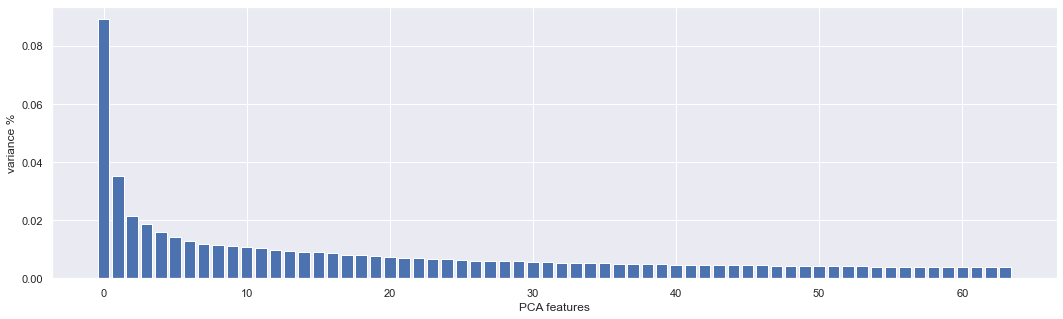

In [50]:
# Plot the explained variances
features = range(pca.n_components_)
f, ax = plt.subplots(figsize=(18,5))
plt.bar(features, pca.explained_variance_ratio_)
plt.xlabel('PCA features')
plt.ylabel('variance %')
#plt.xticks(features)

In [51]:
pca = PCA(n_components = 6)

df_brand_pca = pd.DataFrame(pca.fit_transform(df_brand_units_scaled), index=df_brand_units_scaled.index)
df_brand_pca.columns = df_brand_pca.columns.astype(str)
df_brand_pca = df_brand_pca.add_prefix('PC_')
df_brand_pca

PC_0       PC_1      PC_2       PC_3       PC_4  \
Point-of-Sale_ID                                                         
1                  4.491948 -10.589041  1.175656  -0.199685   3.999400   
2                 -5.273943  -5.513431  0.424284  -2.466199   4.830043   
3                  4.878731 -14.523179 -1.149556  -1.059178  12.184535   
4                 18.107479 -12.499815  5.514281  -1.613558   3.738721   
5                 -2.226095  -6.488970  2.637983  -2.244734   5.235058   
...                     ...        ...       ...        ...        ...   
406               -5.365727  -5.246234 -1.810227  14.234380  -8.330509   
407                6.302886  -9.633559 -7.607458  26.040617  -7.150056   
408               -6.788607  -3.589111 -1.351341  14.366809  -7.390142   
409               -5.790483  -0.658807 -4.805388  13.701445 -10.472838   
410               13.834421  -0.770264 -4.397444  30.696161 -18.493141   

                       PC_5  
Point-of-Sale_ID             
1                 -3.203918  
2                  0.104677  
3                  0.490853  
4                  1.705079  
5                 -1.577038  
...                     ...  
406               -7.410473  
407              -10.175761  
408              -10.191042  
409               -6.641220  
410              -21.572224  

[410 rows x 6 columns]

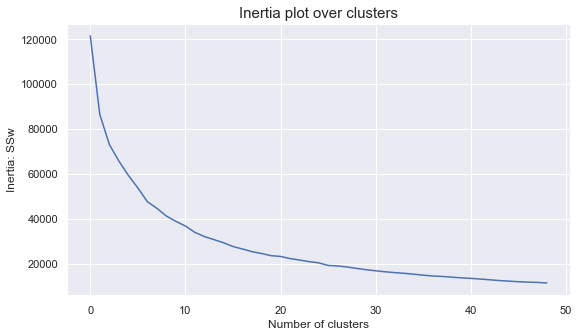

In [52]:
elbow(df_brand_pca)

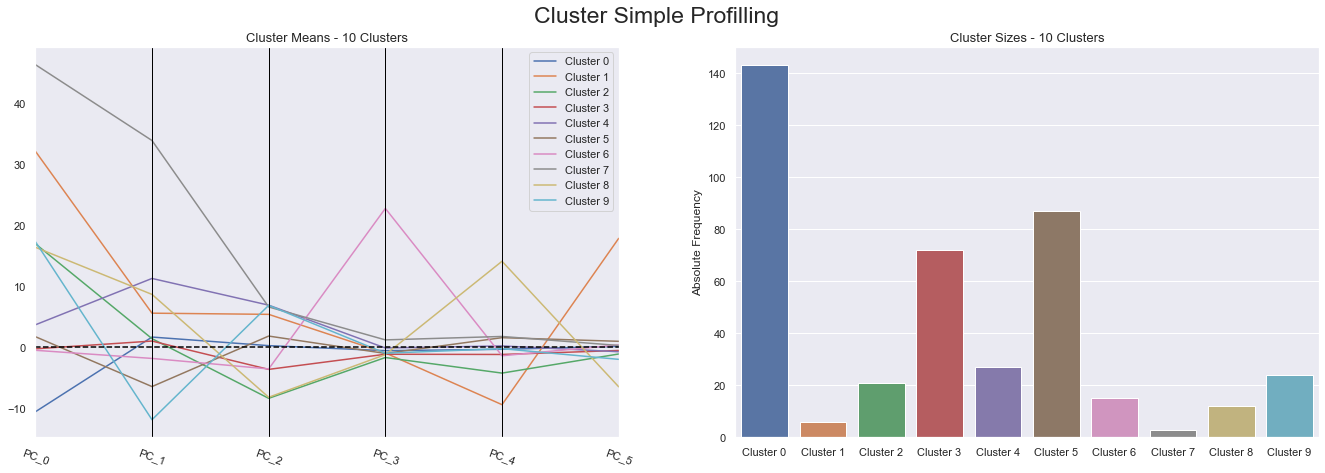

In [53]:
clust_labels, cent = clus_Kmeans(df_brand_pca,10)
kmeans_df_brand = df_brand_pca.copy()
kmeans_df_brand["k_labels_brand"] = clust_labels
cluster_profiles(kmeans_df_brand, ["k_labels_brand"], figsize=(23, 7))

In [54]:
r2(kmeans_df_brand, ["k_labels_brand"])

0.6884584168214032

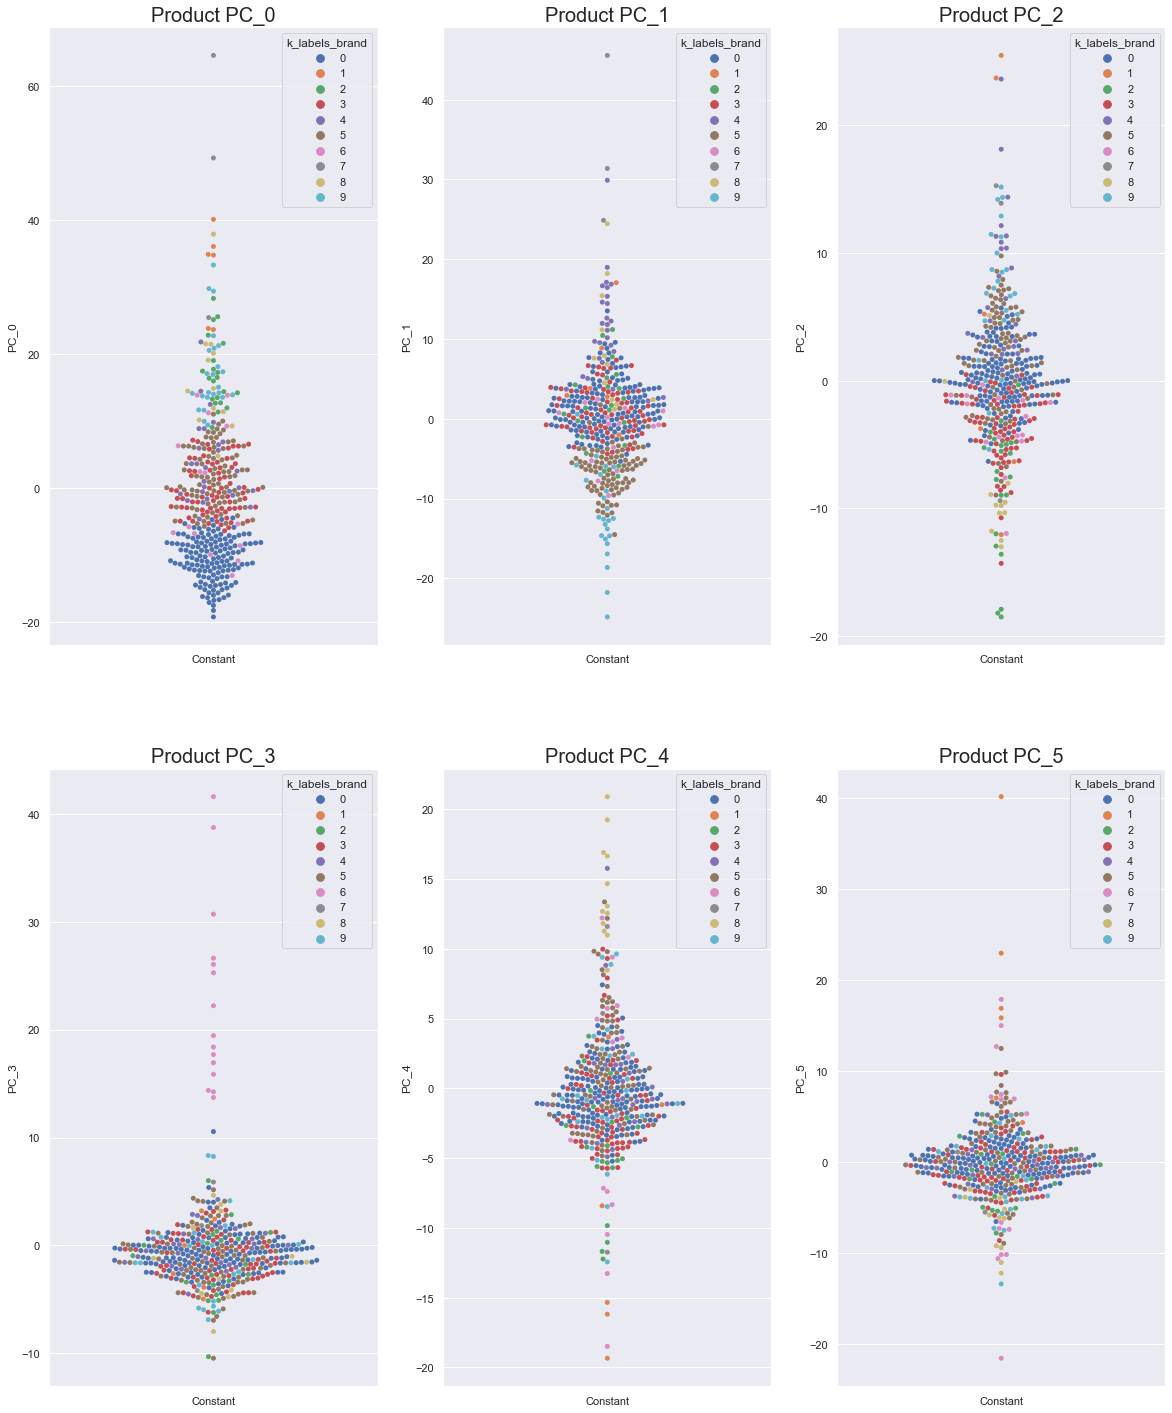

In [55]:
violin_df = kmeans_df_brand.copy()
violin_df['Constant'] = 'Constant'

i = 0
q = 0
sns.set()

fig, axarr = plt.subplots(2,3, figsize=(20, 25))
#swarmplot stripplot
for x in list(kmeans_df_brand.columns[:-1]):
    sns.swarmplot(x=violin_df['Constant'],y=violin_df[x],hue=violin_df['k_labels_brand'], ax=axarr[q][i])
    axarr[q][i].set(xlabel=None)
    axarr[q][i].set_title(f"Product {x}", fontsize=20)
    if i < 2:
        i+=1
    else:
        i=0
        q+=1

Of all analysis made the one with the better performance and with a better understandability of the clusters formation was clustering by family. So we will perform a second analysis but this time instead of using product units will use product value and see the differences

# Clustering by Family but considering product Value

In [50]:
df_fam_price_pivot = grouped_df_fam.pivot(index='Point-of-Sale_ID',columns='ProductFamily_ID', values='Value_price').fillna(0)
df_fam_price_pivot



ProductFamily_ID           1            2           3         4           5   \
Point-of-Sale_ID                                                               
1                  80371664.0  180931760.0  50499980.0  360248.0  4599321.50   
2                  50107436.0  141366992.0  34204940.0   61692.0  3294856.50   
3                  88344656.0  212738880.0  66445536.0  273797.0  5191493.50   
4                  92680800.0  215039440.0  59683088.0  171565.0  5851215.00   
5                  48963300.0  139772800.0  38271996.0  133204.0  3911796.00   
...                       ...          ...         ...       ...         ...   
406                63381832.0  213092320.0  37806144.0  156482.0  2463042.25   
407               105894112.0  339585216.0  87300736.0  490357.0  2609602.25   
408                62778300.0  189388464.0  60374904.0  520690.0  1896772.00   
409                68949416.0  183781632.0  44337248.0  304656.0  1726967.25   
410               124324440.0  284271456.0  62526696.0  553231.0  2981781.25   

ProductFamily_ID          6           7            8            9          10  \
Point-of-Sale_ID                                                                
1                 24687606.0  27031160.0  117523784.0  150359856.0  6922791.0   
2                 16692063.0  24503940.0   89510032.0   89417176.0  2104875.0   
3                 35869640.0  68557768.0  129219432.0  179014832.0  2882834.0   
4                 41973844.0  30038200.0  138575488.0  204110512.0  6882058.0   
5                 19123548.0  19632228.0   65686580.0  125379032.0  2928203.0   
...                      ...         ...          ...          ...        ...   
406               17048050.0  15135363.0   76430000.0  105689144.0  3097158.0   
407               17755650.0  34354324.0  105235384.0  161227376.0  5021447.0   
408                8020681.0  17030542.0   56163500.0   70989616.0  3036310.0   
409               10537648.0  19031800.0   61655164.0   92424432.0  2903620.0   
410               30103896.0  37332220.0  116980496.0  158134992.0  7389214.5   

ProductFamily_ID  ...           12           13          14          15  \
Point-of-Sale_ID  ...                                                     
1                 ...  104689096.0  2685600.000  21670506.0  30273254.0   
2                 ...   67189424.0  1326908.000  14651209.0  20587936.0   
3                 ...   94549904.0  1681699.375  16973194.0  30164920.0   
4                 ...  168781072.0  2604645.000  24018788.0  35467036.0   
5                 ...   78527840.0  1427142.000  13025306.0  18700392.0   
...               ...          ...          ...         ...         ...   
406               ...   88627128.0  1537620.000  12420653.0  15321890.0   
407               ...  131948664.0  2864456.750  23754940.0  27362168.0   
408               ...   77065968.0  1897899.500  14150678.0  20281994.0   
409               ...   83937472.0  1659128.000  13794884.0  12031156.0   
410               ...  181358176.0  3193168.250  34723160.0  24583284.0   

ProductFamily_ID          16           17           18          19         20  \
Point-of-Sale_ID                                                                
1                  6693937.0  377177.0000   70038472.0   5495324.0   368610.0   
2                  5923798.5   42503.0000   37395816.0   2713600.0   143660.0   
3                  6540684.0  185203.0000   44911988.0   5162200.0   122807.0   
4                  5598549.0  439672.0000   63436620.0  14685417.0   967635.0   
5                  4420216.0  170638.0000   39990252.0   3927300.0   324897.0   
...                      ...          ...          ...         ...        ...   
406                5148250.5  204441.0000   66062124.0   5474900.0   669674.0   
407               10263211.0  244012.0625  112577752.0   3794800.0   908314.0   
408                7678284.0   36701.0000   68723680.0   3275411.0   113714.0   
409                4050440.0   97528.0

In [51]:
scaler = StandardScaler()
df_fam_price_scaled = pd.DataFrame(scaler.fit_transform(df_fam_price_pivot),columns=df_fam_price_pivot.columns, index=df_fam_price_pivot.index)
df_fam_price_scaled



ProductFamily_ID        1         2         3         4         5         6   \
Point-of-Sale_ID                                                               
1                 0.537278  0.443593  1.236504  0.135235  1.165856  0.437927   
2                -0.485370 -0.127154  0.273100 -1.301836  0.297932 -0.279717   
3                 0.806691  0.902432  2.179245 -0.280888  1.559857  1.441577   
4                 0.953212  0.935619  1.779433 -0.772973  1.998802  1.989463   
5                -0.524032 -0.150151  0.513554 -0.957620  0.708412 -0.061478   
...                    ...       ...       ...       ...       ...       ...   
406              -0.036820  0.907530  0.486012 -0.845573 -0.255515 -0.247765   
407               1.399699  2.732273  3.412258  0.761503 -0.158001 -0.184254   
408              -0.057213  0.565587  1.820335  0.907508 -0.632282 -1.058021   
409               0.151313  0.484705  0.872148 -0.132352 -0.745262 -0.832110   
410               2.022472  1.934336  1.947554  1.064141  0.089627  0.924069   

ProductFamily_ID        7         8         9         10  ...        12  \
Point-of-Sale_ID                                          ...             
1                 0.232182  0.766431  0.769178  0.786226  ...  0.217816   
2                 0.042259  0.054769 -0.450740 -0.924907  ... -0.633243   
3                 3.352956  1.063547  1.342779 -0.648607  ... -0.012294   
4                 0.458165  1.301229  1.845131  0.771759  ...  1.672389   
5                -0.323856 -0.550443  0.269125 -0.632493  ... -0.375916   
...                    ...       ...       ...       ...  ...       ...   
406              -0.661801 -0.277516 -0.125017 -0.572487  ... -0.146712   
407               0.782527  0.454256  0.986719  0.110944  ...  0.836474   
408              -0.519376 -0.792367 -0.819614 -0.594098  ... -0.409094   
409              -0.368979 -0.652857 -0.390543 -0.641224  ... -0.253144   
410               1.006319  0.752629  0.924817  0.951881  ...  1.957828   

ProductFamily_ID        13        14        15        16        17        18  \
Point-of-Sale_ID                                                               
1                 0.966498  0.172460  0.906396  0.533003 -0.128374  0.871776   
2                -0.348711 -0.502929 -0.078333  0.267695 -0.921415 -0.478837   
3                -0.005274 -0.279510  0.895381  0.480209 -0.583274 -0.167850   
4                 0.888134  0.398409  1.434460  0.155648  0.019714  0.598619   
5                -0.251685 -0.659371 -0.270244 -0.250282 -0.617787 -0.371491   
...                    ...       ...       ...       ...       ...       ...   
406              -0.144743 -0.717550 -0.613744  0.000522 -0.537688  0.707251   
407               1.139631  0.373021  0.610419  1.762600 -0.443921  2.631868   
408               0.204007 -0.551089 -0.109439  0.872106 -0.935163  0.817375   
409              -0.027123 -0.585323 -0.948320 -0.377668 -0.791028  0.728422   
410               1.457823  1.428370  0.327883  2.116574 -0.666741  2.670074   

ProductFamily_ID        19        20        21  
Point-of-Sale_ID                                
1                -0.354381 -0.595116  0.116836  
2                -0.911022 -0.687392 -0.702063  
3                -0.421041 -0.695946 -0.354465  
4                 1.484618 -0.349391  0.904065  
5                -0.668153 -0.613047 -0.572061  
...                    ...       ...       ...  
406              -0.358468 -0.471617 -0.393366  
407              -0.694667 -0.373725  0.085720  
408              -0.798600 -0.699676 -0.565244  
409              -0.117717 -0.649470 -0.562593  
410               0.779519 -0.065357  0.981932  

[410 rows x 21 columns]

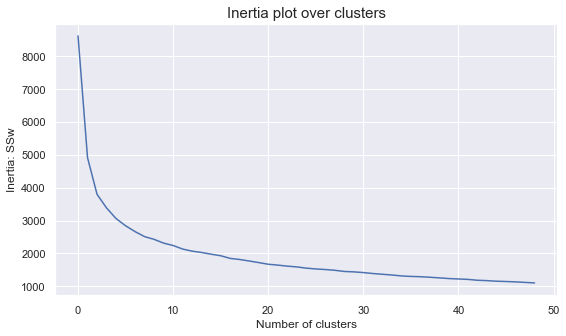

In [52]:
elbow(df_fam_price_scaled)


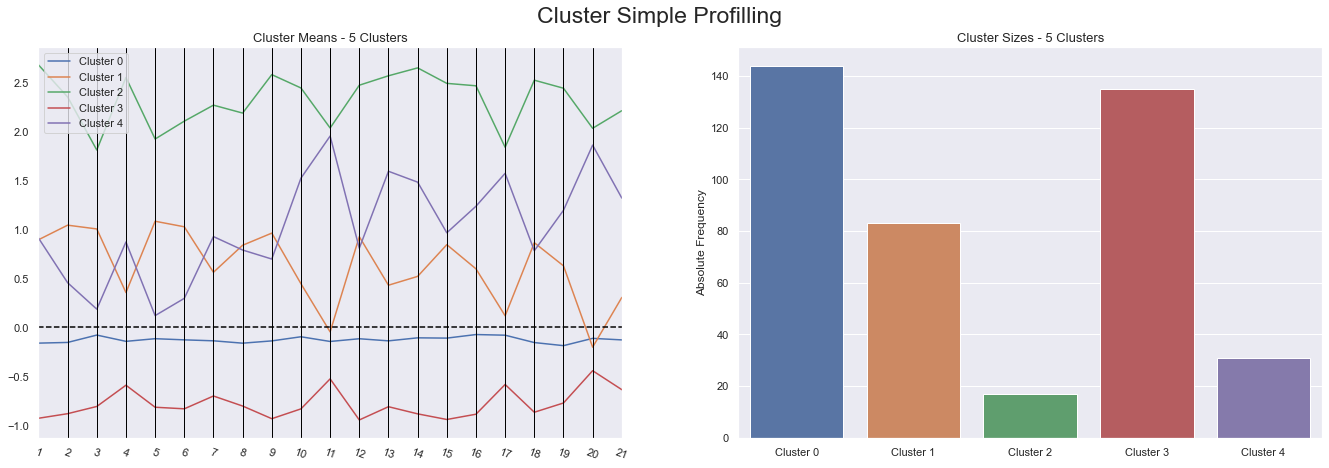

In [53]:

clust_labels, cent = clus_Kmeans(df_fam_price_scaled, 5)
kmeans_df_fam_price = df_fam_price_scaled.copy()
kmeans_df_fam_price["k_labels_fam_price"] = clust_labels
cluster_profiles(kmeans_df_fam_price, ["k_labels_fam_price"], figsize=(23, 7))



In [54]:
r2(kmeans_df_fam_price, ["k_labels_fam_price"])

0.6762081881519532

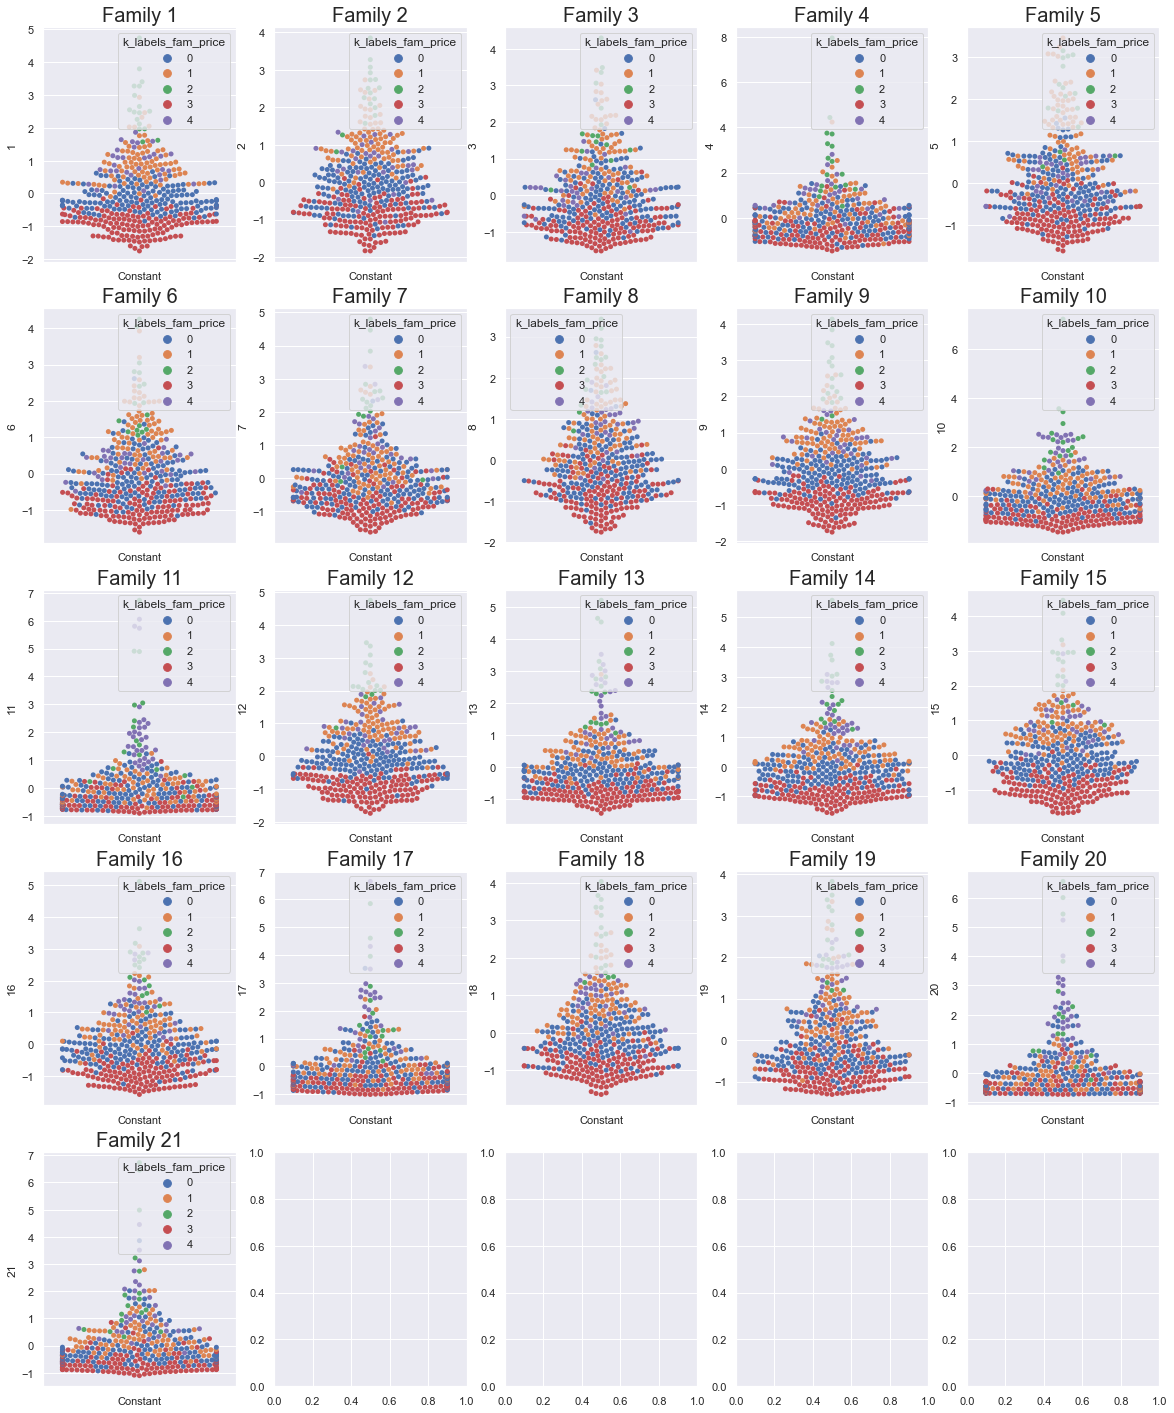

In [55]:
violin_df = kmeans_df_fam_price.copy()
violin_df['Constant'] = 'Constant'

i = 0
q = 0
sns.set()

fig, axarr = plt.subplots(5,5, figsize=(20, 25))
#swarmplot stripplot
for x in list(violin_df.columns[:-2]):
    sns.swarmplot(x=violin_df['Constant'],y=violin_df[x],hue=violin_df['k_labels_fam_price'], ax=axarr[q][i])
    axarr[q][i].set(xlabel=None)
    axarr[q][i].set_title(f"Family {x}", fontsize=20)
    if i < 4:
        i+=1
    else:
        i=0
        q+=1
        


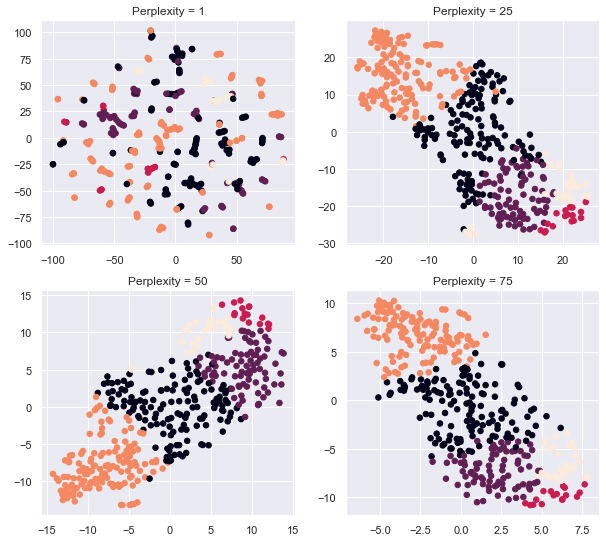

In [62]:
#check different perplexity levels for 2D visualization

plt.figure(figsize = (10,5))
plt.subplots_adjust(top = 1.5)

for index, p in enumerate([1, 25, 50, 75]):

    tsne = TSNE(n_components = 2, perplexity = p, random_state=0)
    tsne_results = tsne.fit_transform(df_fam_price_scaled)
    
    tsne_results=pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2'])
    
    plt.subplot(2,2,index+1)
    plt.scatter(tsne_results['tsne1'], tsne_results['tsne2'], c=kmeans_df_fam_price['k_labels_fam_price'], s=30)
    plt.title('Perplexity = '+ str(p))
plt.show()

Clustering by product value or by product units leads to very similar clusters

Considering that products can be considered to be a categorical variable, we found interesting to implement a clustering analysis using Kprototypes, which is able to create clusters using both categorical and numerical data.


# Clustering using Kprototypes

In [5]:
#create a reduced dataframe with only the relevant information
df_name = df[['Point-of-Sale_ID','Date','ProductName_ID','Value_units','Value_price']]

#create a feature to keep track of the week and year of the transaction
df_name['Week'] = df['Date'].dt.year.astype(str) + 'W' + df['Date'].dt.week.astype(str)

In [6]:
grouped_df_units = df_name.groupby(['Point-of-Sale_ID','ProductName_ID'])['Value_units'].sum().to_frame()
grouped_df_units.reset_index(inplace=True)

df_units_pivot = grouped_df_units.pivot(index='Point-of-Sale_ID',columns='ProductName_ID', values='Value_units').fillna(0)

# find the top 10 mbest seller products in each store and save it to new columns
df_units = pd.DataFrame(df_units_pivot.columns.values[np.argsort(-df_units_pivot.values, axis=1)[:, :10]], 
                  index=df_units_pivot.index,
                  columns = ['Top 1','Top 2','Top 3',
                            'Top 4','Top 5','Top 6',
                            'Top 7','Top 8','Top 9',
                            'Top 10']).reset_index()
df_units.set_index('Point-of-Sale_ID',inplace=True)

In [8]:
#group price and units by weekly transactions
weekly_sales = df_name[['Value_price','Point-of-Sale_ID','Week']].groupby(['Point-of-Sale_ID','Week']).sum().groupby('Point-of-Sale_ID').mean()
weekly_units = df_name[['Value_units','Point-of-Sale_ID','Week']].groupby(['Point-of-Sale_ID','Week']).sum().groupby('Point-of-Sale_ID').mean()

df_units = df_units.merge(weekly_sales['Value_price'],left_on='Point-of-Sale_ID' ,left_index=False, right_index=True)
df_units = df_units.merge(weekly_units['Value_units'],left_on='Point-of-Sale_ID' ,left_index=False, right_index=True)

#set the new columns has a category
for x in ['Top 1','Top 2','Top 3','Top 4','Top 5','Top 6','Top 7','Top 8','Top 9', 'Top 10']:
    df_units[x] = df_units[x].astype('category')

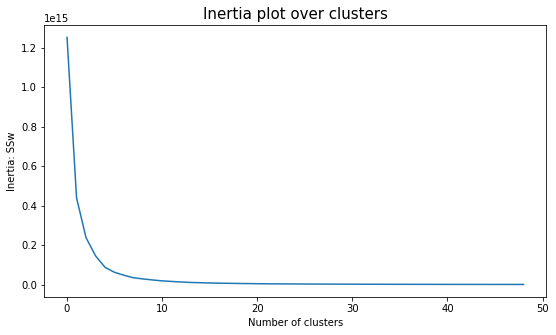

In [13]:
elbow(df_units)

In [14]:
#create the KPrototypes, setting the prodcuts columns has categorical
pred = KPrototypes(n_clusters=5).fit_predict(df_units, categorical=[0,1,2,3,4,5,6,7,8,9])

In [15]:
df_units["clusters"] = pred
df_units

Top 1 Top 2 Top 3 Top 4 Top 5 Top 6 Top 7 Top 8 Top 9 Top 10  \
Point-of-Sale_ID                                                                
1                  226  1846  2412  1766  1277  2346   993   811  1855   1234   
2                  226  1761   219  1408  2802  1422   993   912  1147   2692   
3                  216   198  1422  2802   226   847   912  1956   993   1059   
4                 1422  1234  2609   226   993   196   567  1277  2685   2379   
5                  226  1846  1277  1422  1234   567  2685  2609   847    811   
...                ...   ...   ...   ...   ...   ...   ...   ...   ...    ...   
406                231  1855  1277  1766  2412  1224  1853  1762  1786    307   
407               1277  1762   228  1853   231    55  1059  2409  1786    216   
408                231   228  1277  1853  2409  1855  1762  1786  1059     55   
409               1277   210  1762   228  1853  1786  2409  2343    55    207   
410                231  1277  1855  1786    55   130  1762   228  1853   2404   

                  Value_price  Value_units  clusters  
Point-of-Sale_ID                                      
1                  4870010.50  3032.353271         3  
2                  3162023.00  1942.845825         2  
3                  5215533.50  2997.104492         3  
4                  6276052.50  3968.850830         1  
5                  3324393.00  2104.815918         2  
...                       ...          ...       ...  
406                3915781.75  2461.811035         3  
407                6291750.50  3910.109375         1  
408                3522901.25  2272.313477         2  
409                3578587.00  2216.010010         2  
410                6780864.00  4326.572266         1  

[410 rows x 13 columns]

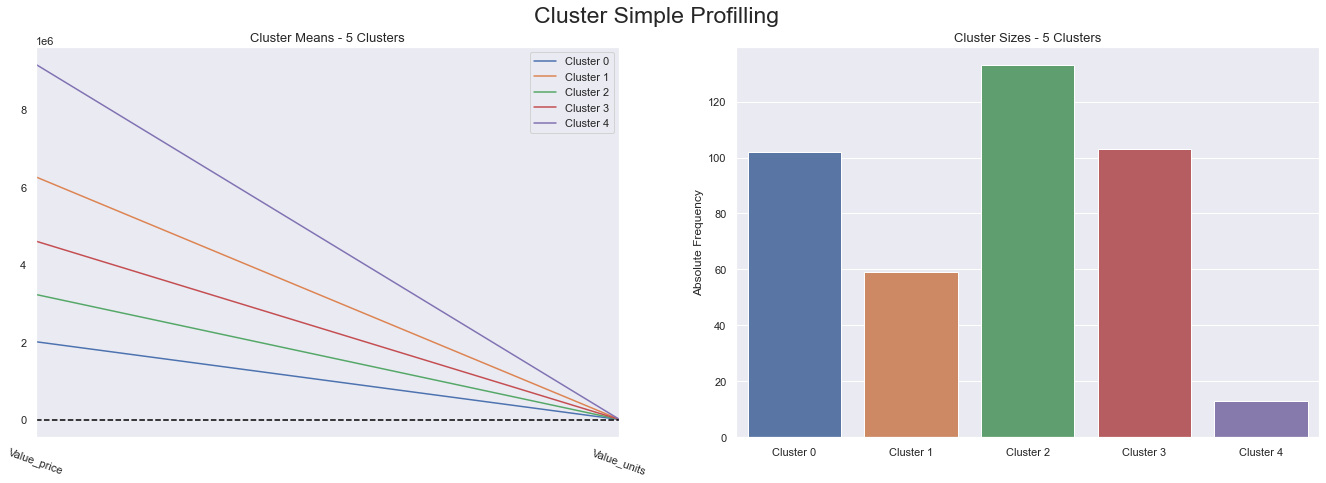

In [35]:
#Only two variable appear on the line chart because all other variables are categorical and that chart only deal with numeric.
cluster_profiles(df_units, ["clusters"], figsize=(23, 7))

In [16]:
#merge the cluster to the orginal dataframe
df_name = df.merge(df_units['clusters'],left_on='Point-of-Sale_ID' ,left_index=False, right_index=True)
df_name

ProductFamily_ID  ProductCategory_ID  ProductBrand_ID  \
0                       16                  11              306   
1                       16                  11              306   
2                       16                  11              306   
3                       16                  11              306   
4                       16                  11              306   
...                    ...                 ...              ...   
91191593                 4                  34              279   
91191594                 4                  34              279   
91191595                 4                  34              279   
91191596                 4                  34              279   
91191597                 4                  34              279   

          ProductName_ID  ProductPackSKU_ID  Point-of-Sale_ID       Date  \
0                    649               1970                 1 2017-03-04   
1                    649               1970                 1 2016-05-02   
2                    649               1970                 1 2016-10-24   
3                    649               1970                 1 2017-10-13   
4                    649               1970                 1 2017-10-14   
...                  ...                ...               ...        ...   
91191593             577               1813               410 2016-01-28   
91191594             577               1813               410 2016-04-20   
91191595             577               1813               410 2016-04-25   
91191596             577               1813               410 2016-04-28   
91191597             577               1813               410 2016-04-29   

          Value_units  Value_price  Unit_Price  Retail_price  Is_Promo  \
0                 2.0       1540.0       770.0         810.0         0   
1                 4.0       3080.0       770.0         810.0         0   
2                 2.0       1540.0       770.0         810.0         0   
3                 2.0       1620.0       810.0         810.0         0   
4                 2.0       1620.0       810.0         810.0         0   
...               ...          ...         ...           ...       ...   
91191593          1.0        643.0       643.0         810.0         1   
91191594          1.0        638.0       638.0         810.0         1   
91191595          1.0        652.0       652.0         810.0         1   
91191596          1.0        643.0       643.0         810.0         1   
91191597          1.0        638.0       638.0         810.0         1   

          clusters  
0                3  
1                3  
2                3  
3                3  
4                3  
...            ...  
91191593         1  
91191594         1  
91191595         1  
91191596         1  
91191597         1  

[91191598 rows x 13 columns]

In [ ]:
#save the dataframe with the clusters
df_name.to_csv('../Databases/df_clusters.csv')